# Lab Assignment 3: Introduction to Speech Processing

# Name: Saran Jayakumar Palani
# Reg No: BL.EN.U4AIE23131

# Objective 1

In [22]:
import torch
import torchaudio
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from pydub import AudioSegment
import os
import warnings
warnings.filterwarnings('ignore')

1. Load and preprocess the recorded speech signal.

In [23]:
def convert_m4a_to_wav(m4a_path, wav_path):
    try:
        audio = AudioSegment.from_file(m4a_path, format="m4a")
        audio = audio.set_channels(1)
        audio.export(wav_path, format="wav")
        print(f"Converted {m4a_path} to {wav_path}")
        return wav_path
    except Exception as e:
        print(f"Error converting audio: {e}")
        return None

audio_path = "Rec1.m4a"
wav_path = "Rec1.wav"

if not os.path.exists(wav_path):
    convert_m4a_to_wav(audio_path, wav_path)

# Load audio using librosa
waveform_np, sr = librosa.load(wav_path, sr=None, mono=True)
waveform = torch.from_numpy(waveform_np)

# Resample to 16 kHz if necessary
if sr != 16000:
    waveform_np_resampled = librosa.resample(y=waveform.numpy(), orig_sr=sr, target_sr=16000)
    waveform = torch.from_numpy(waveform_np_resampled)
    sr = 16000

duration = len(waveform) / sr

print("Sampling rate:", sr)
print("Duration (s):", round(duration, 2))

Sampling rate: 16000
Duration (s): 7.74


2. Automatically segment the speech into phoneme-level units (similar to previous lab).

In [24]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
model.eval()

Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [25]:
inputs = processor(
    waveform.numpy(),
    sampling_rate=sr,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_ids = torch.argmax(logits, dim=-1)[0]
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids)

print("CTC Tokens:")
print(tokens[:60])

CTC Tokens:
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'S', 'H', 'H', '<pad>', '<pad>', 'E', '<pad>', '<pad>']


In [26]:
num_frames = logits.shape[1]
time_per_token = duration / num_frames

collapsed_tokens = []
collapsed_times = []

prev = None
for i, tok in enumerate(tokens):
    if tok != prev and tok != processor.tokenizer.pad_token:
        collapsed_tokens.append(tok)
        collapsed_times.append(i * time_per_token)
    prev = tok

# Create phoneme segments
phonemes = collapsed_tokens
phoneme_times = []
for i in range(len(collapsed_times)):
    start = collapsed_times[i]
    end = collapsed_times[i+1] if i+1 < len(collapsed_times) else duration
    phoneme_times.append((start, end))

print("\nCollapsed Tokens:")
print(collapsed_tokens)
print("Time per token:", round(time_per_token, 4), "s")


Collapsed Tokens:
['S', 'H', 'E', '|', 'J', 'U', 'D', 'G', 'E', 'D', '|', 'H', 'E', '|', 'B', 'L', 'U', 'E', '|', 'P', 'A', 'N', 'D', '|', 'P', 'U', 'T', '|', 'I', 'T', '|', 'O', 'U', 'N', '|', 'E', 'R', '|', 'D', 'A', 'Y', '|', 'V', 'A', 'T', 'E', '|', 'A', 'N', '|', 'Q', 'U', 'I', 'E', 'T', 'L', 'Y', '|', 'W', 'I', 'P', 'E', 'R', 'E', 'D', '|', 'Y', 'E', 'S', '|']
Time per token: 0.0201 s


3. Plot the time-domain waveform corresponding to each extracted phoneme.

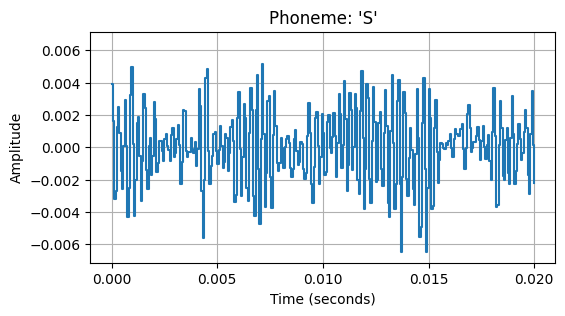

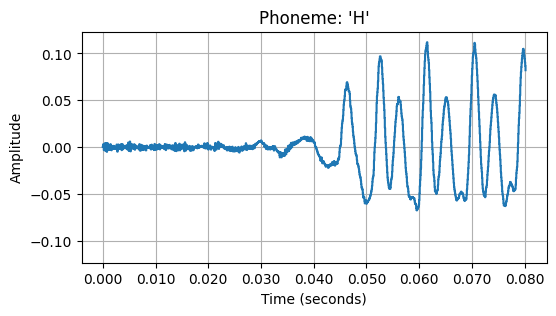

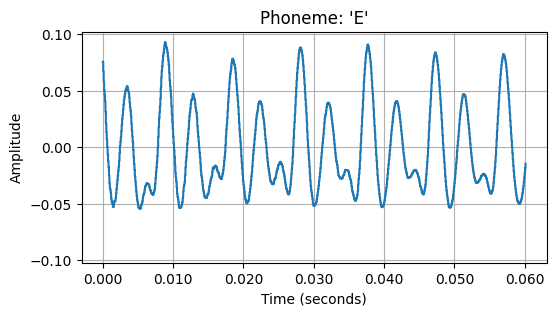

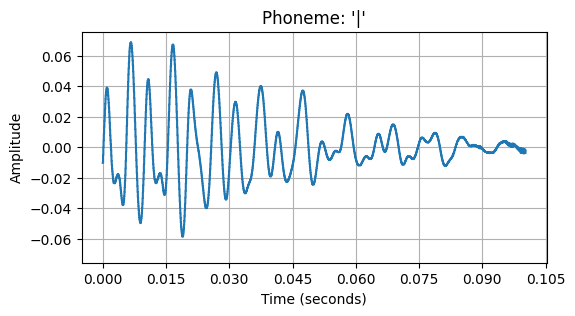

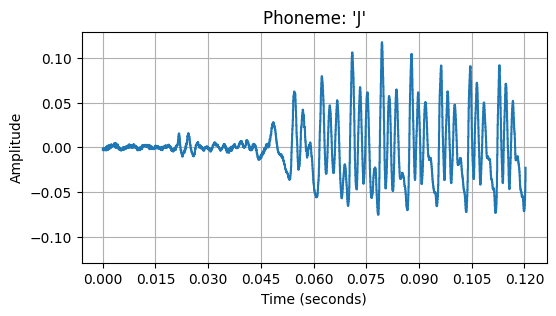

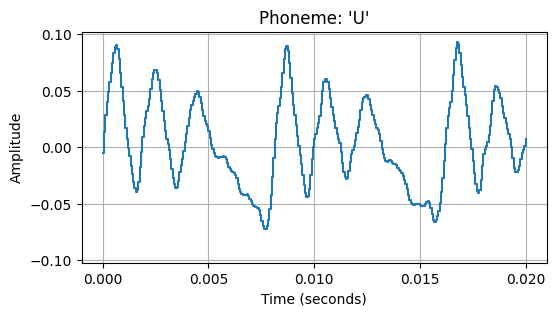

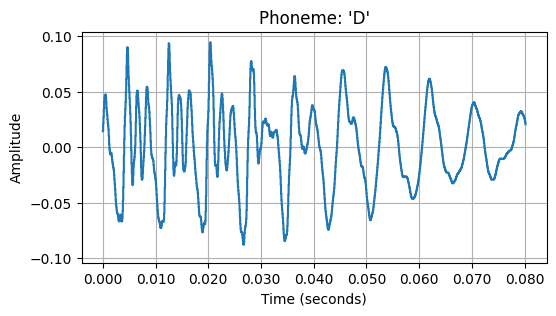

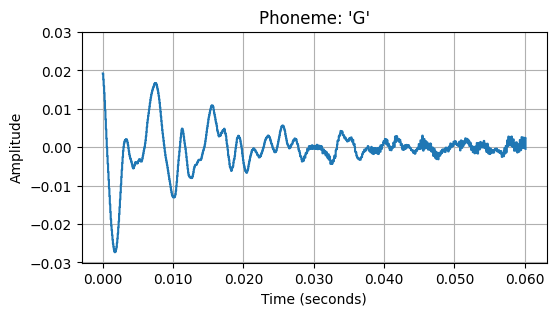

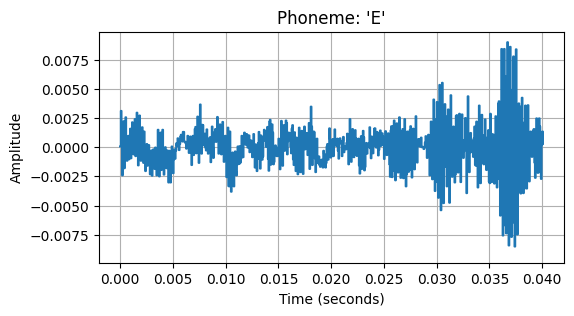

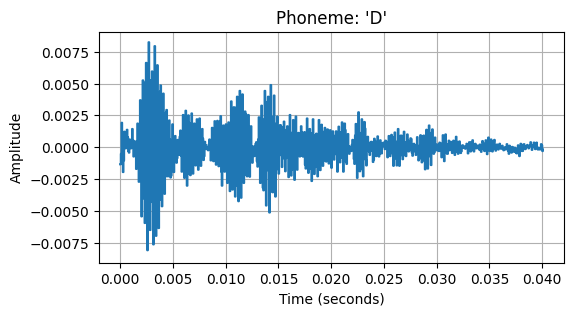

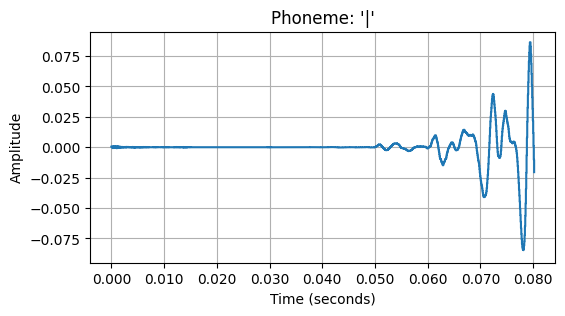

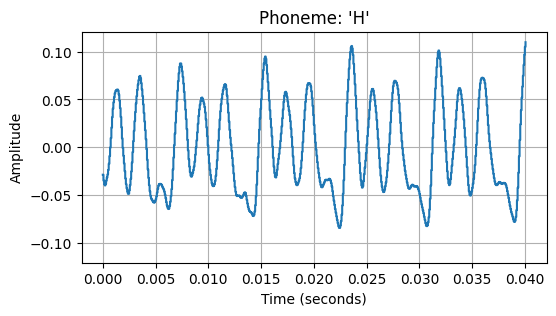

In [27]:
for ph, (t1, t2) in zip(phonemes[:12], phoneme_times[:12]):  # First 12 phonemes
    start_sample = int(t1 * sr)
    end_sample = int(min(t2 * sr, len(waveform)))
    segment = waveform[start_sample:end_sample]

    if len(segment) < 300:
        continue

    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(segment.numpy(), sr=sr)
    plt.title(f"Phoneme: '{ph}'")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

4. For every phoneme segment:
✓ Identify its phoneme category (vowel, plosive, fricative, affricate, semivowel, diphthong, or whisper segment).
✓ Label the phoneme accordingly.

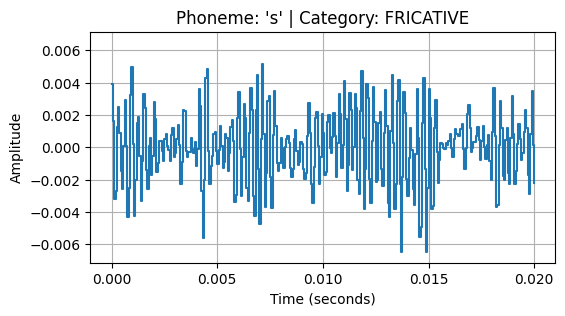

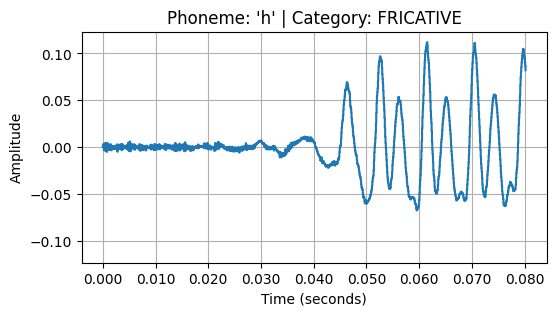

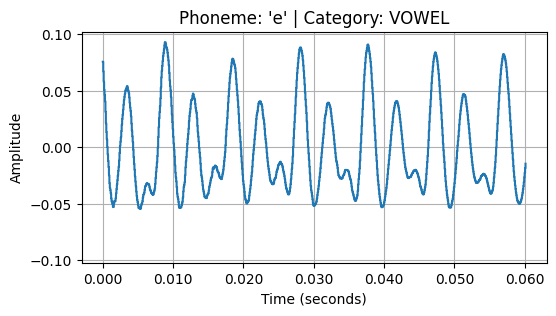

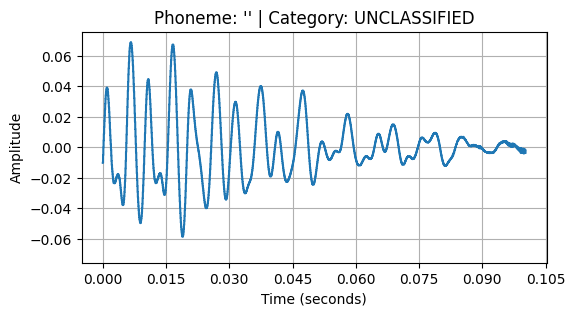

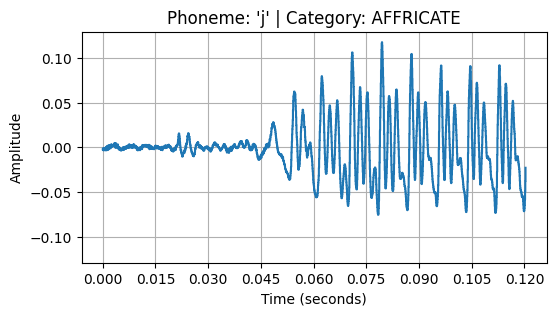

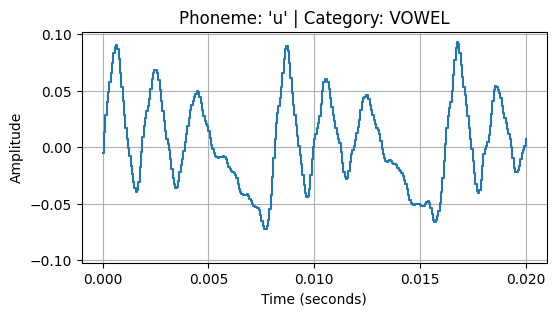

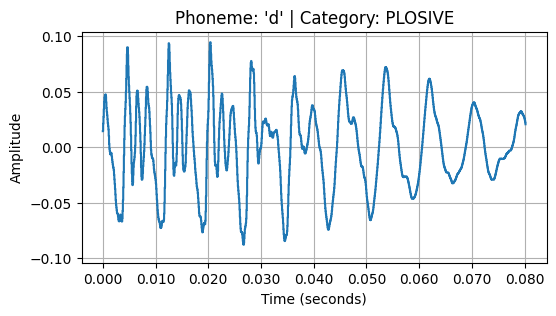

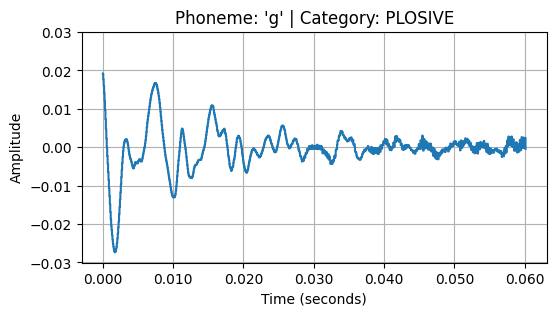

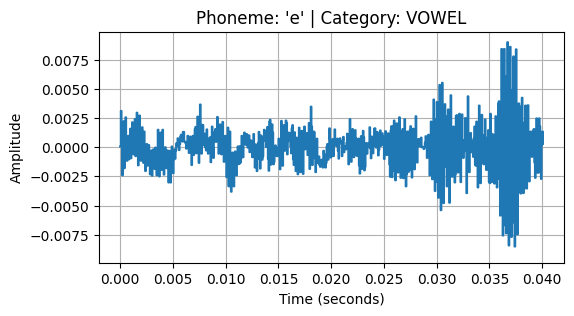

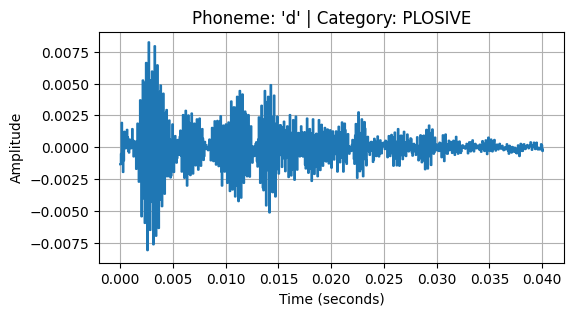

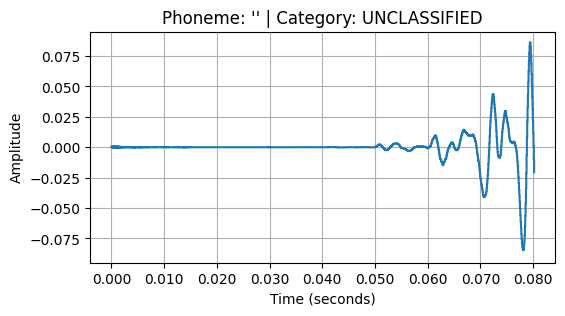

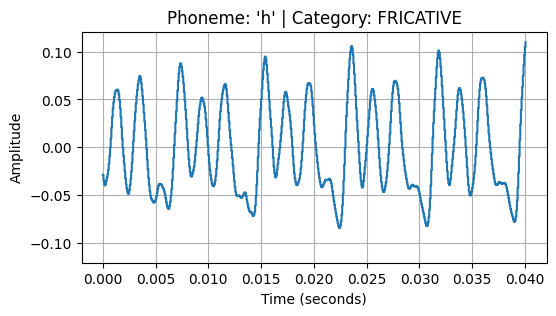

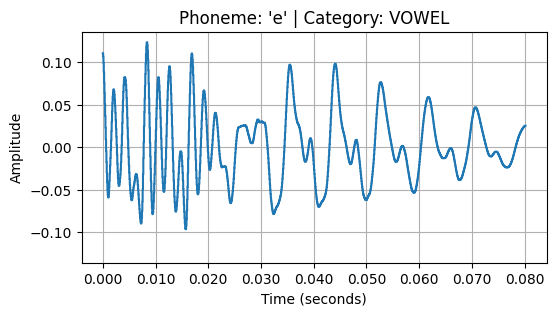

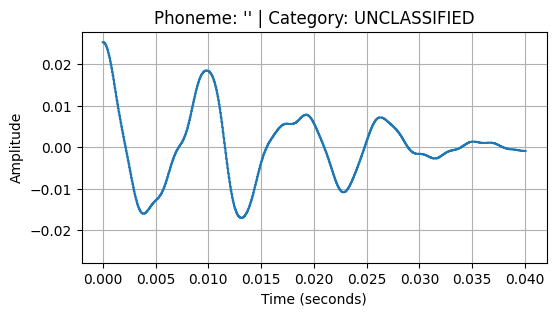

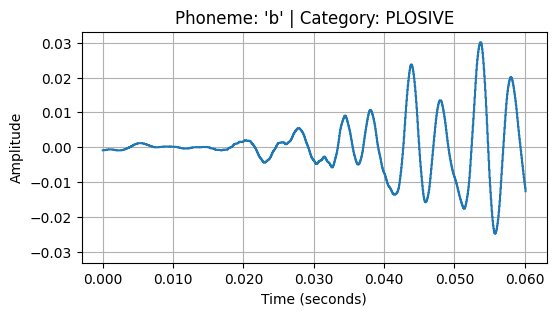

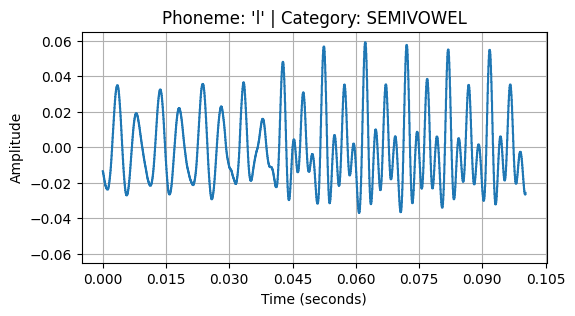

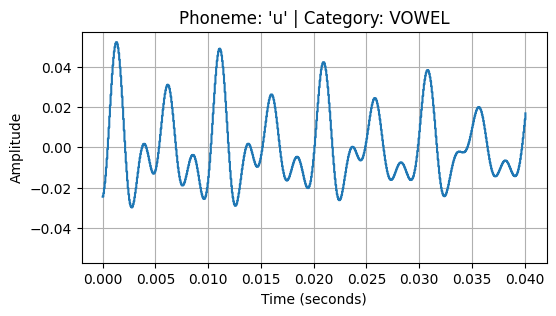

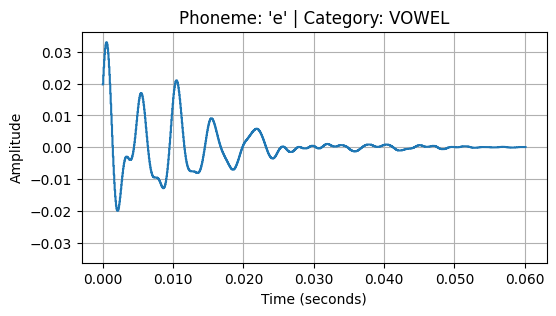

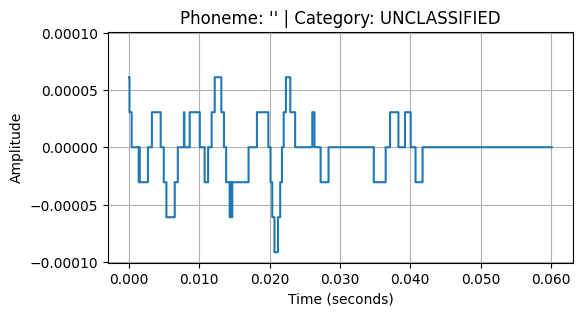

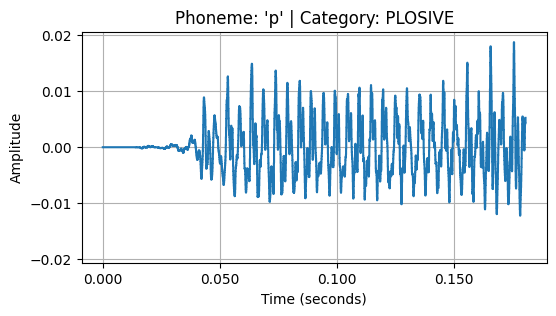

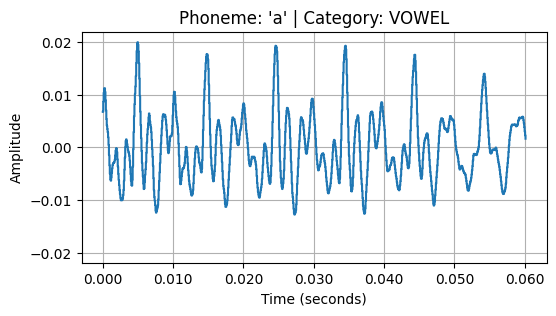

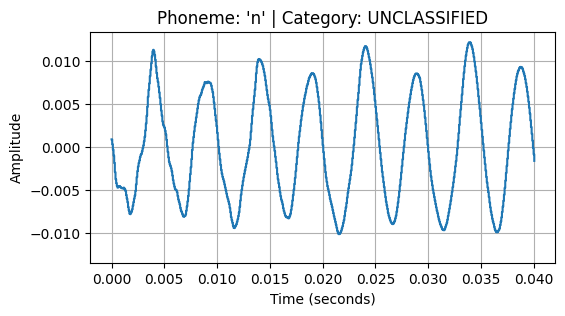

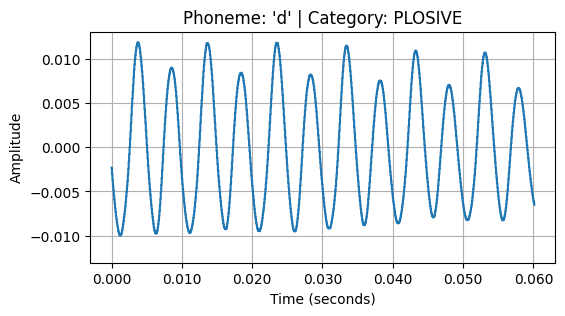

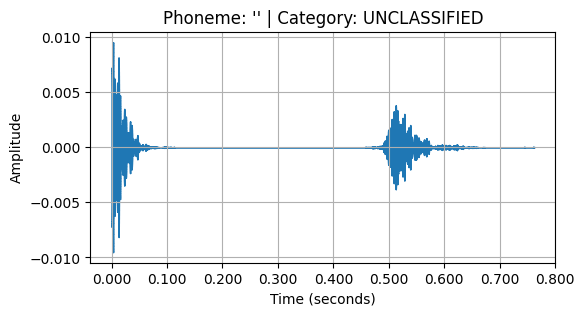

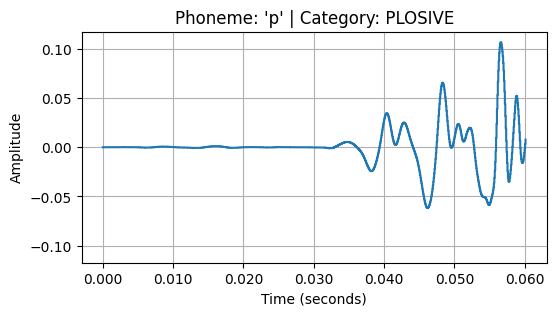

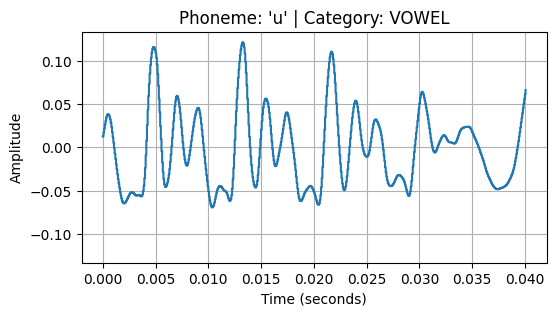

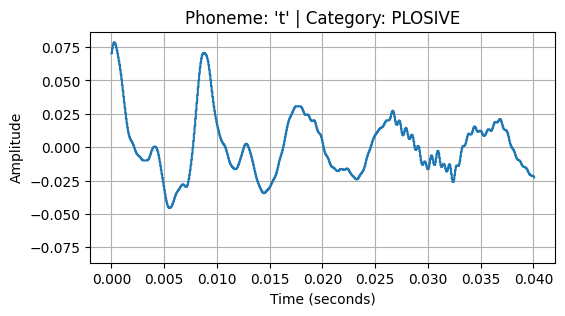

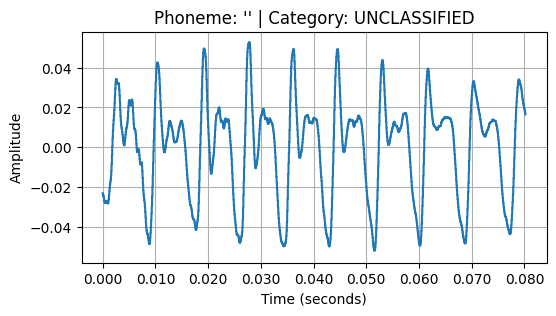

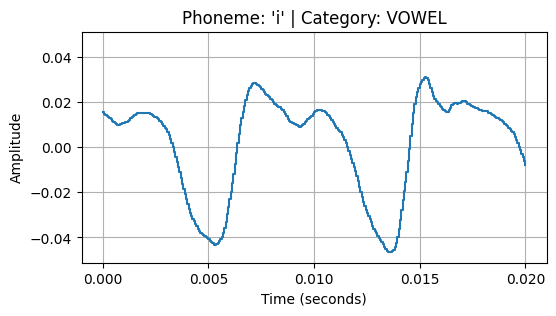

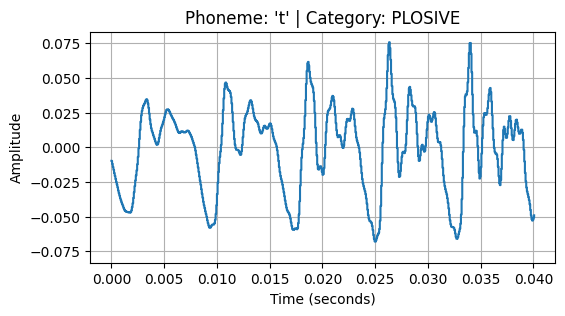

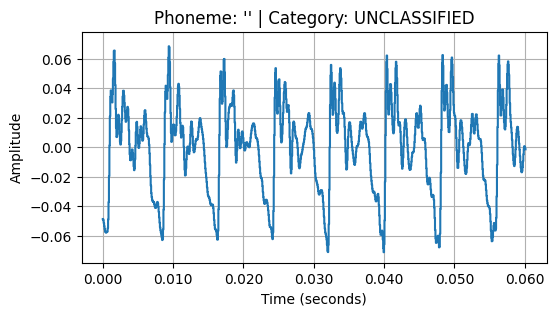

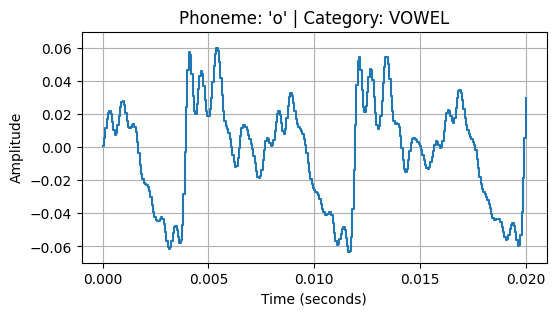

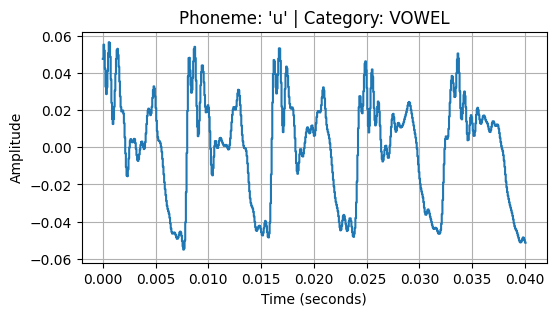

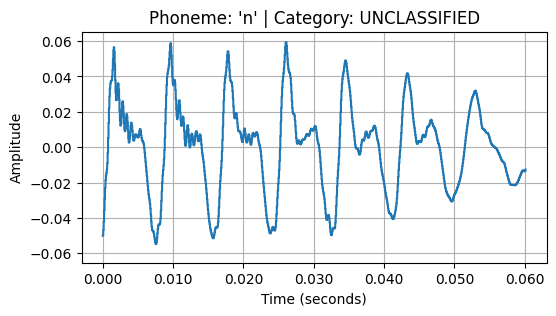

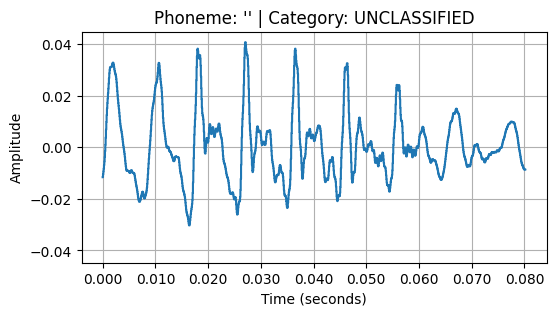

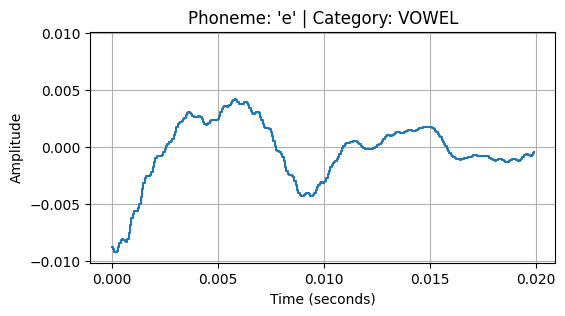

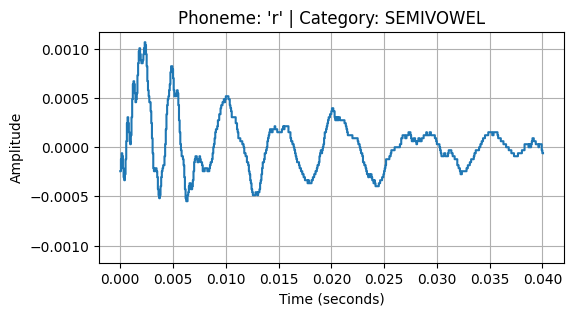

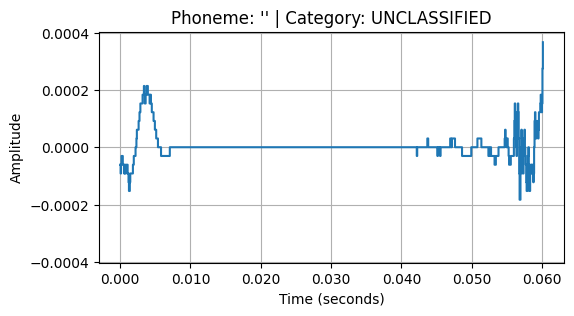

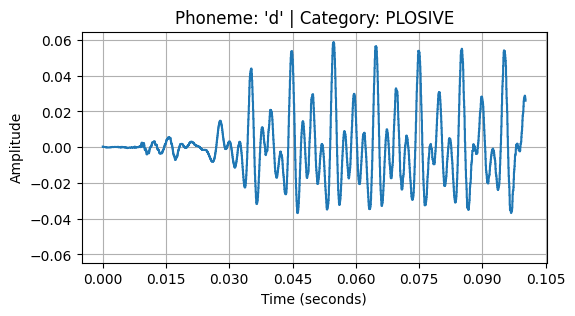

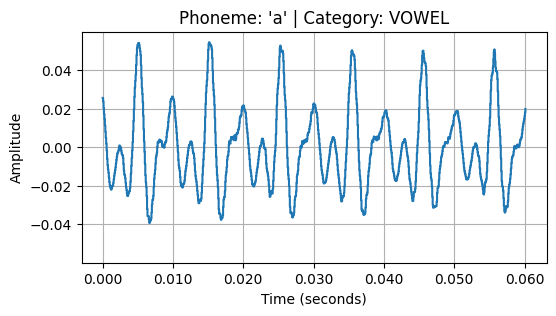

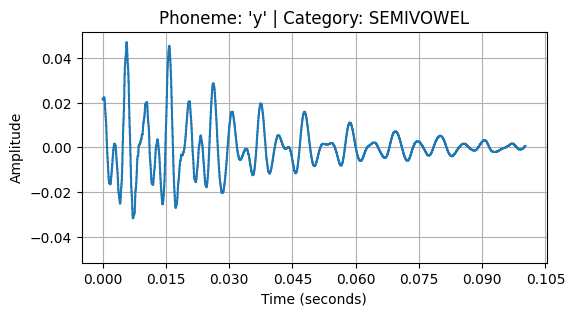

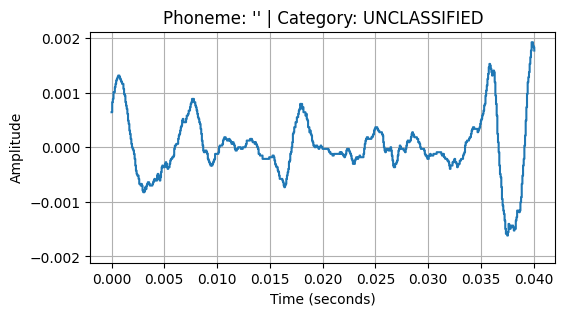

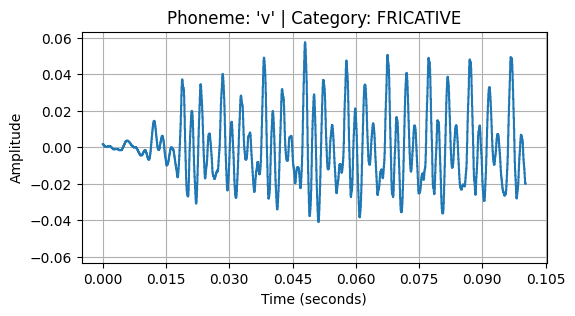

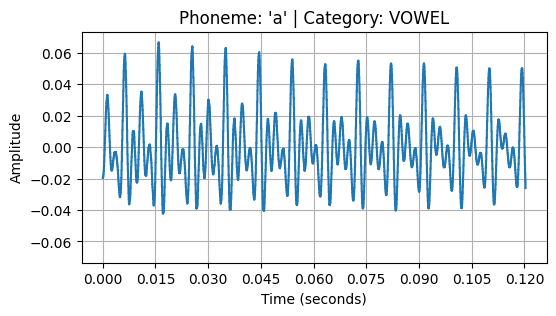

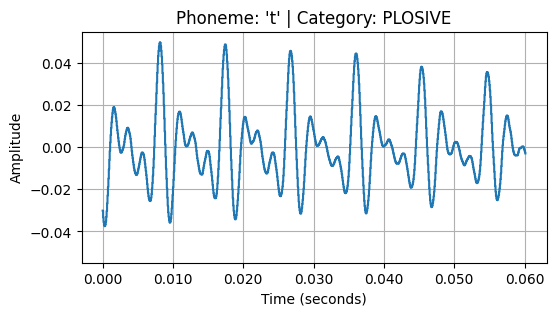

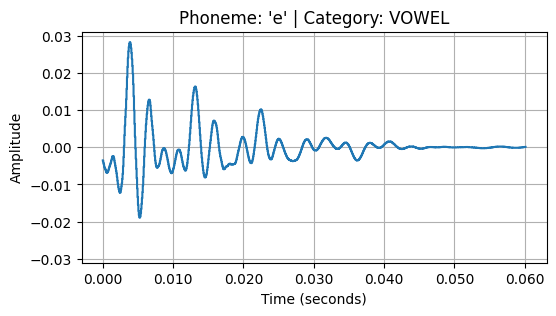

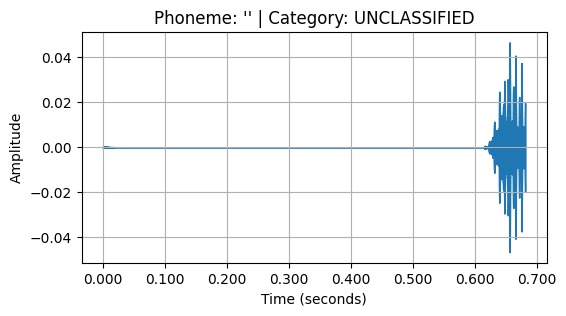

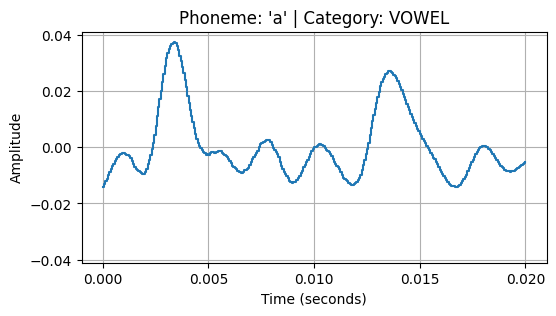

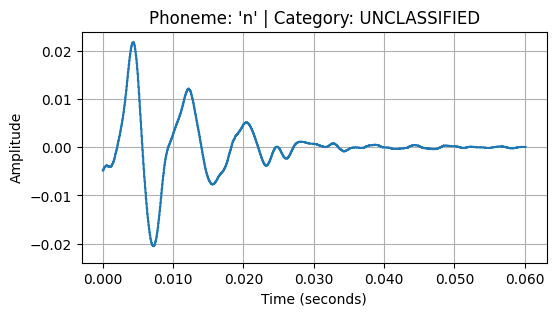

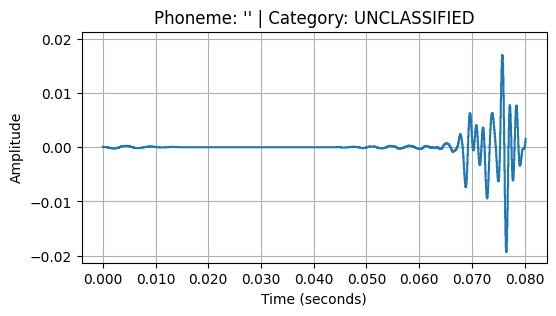

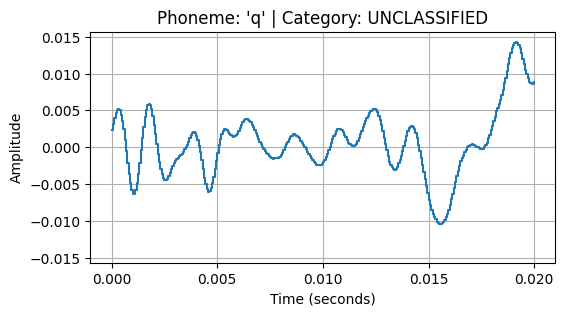

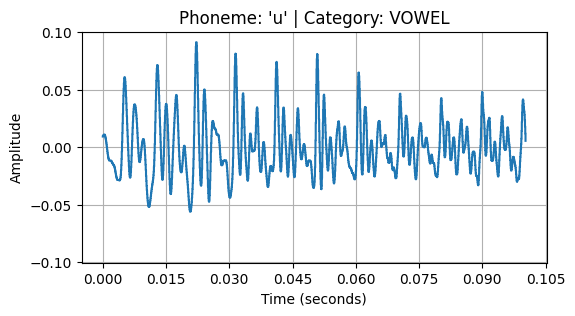

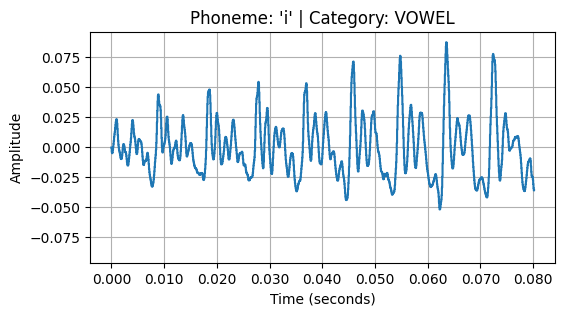

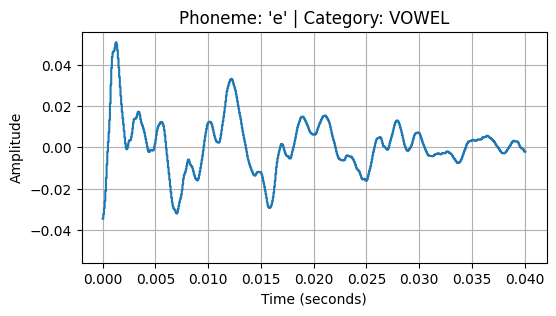

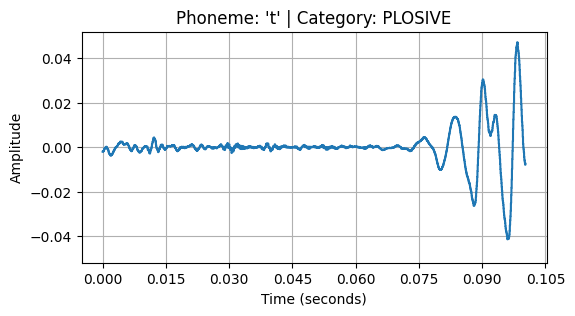

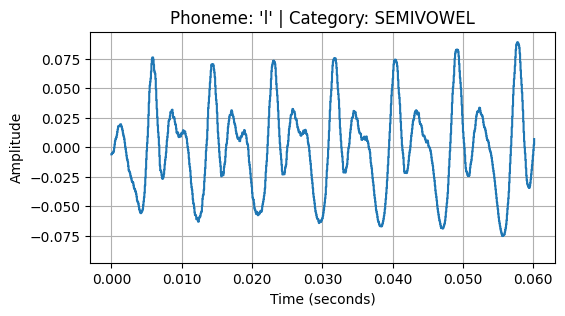

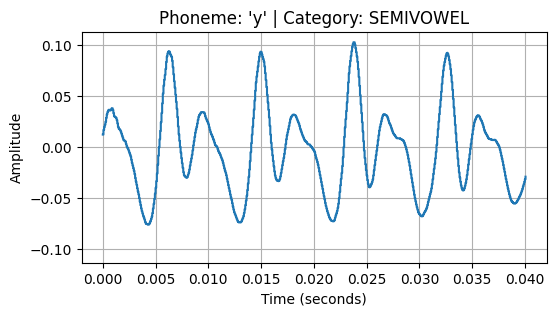

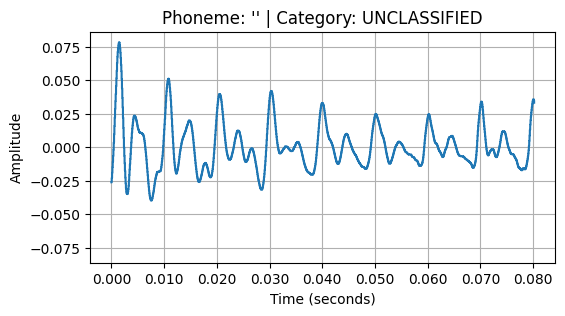

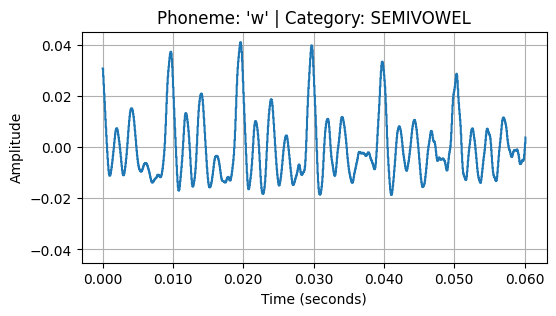

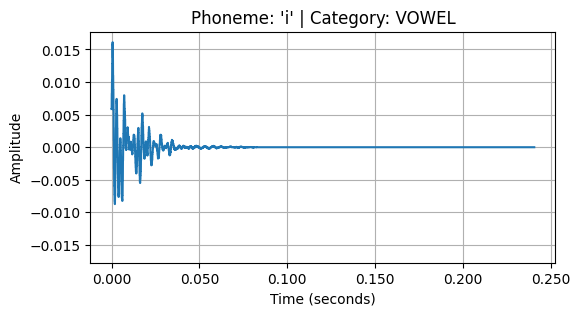

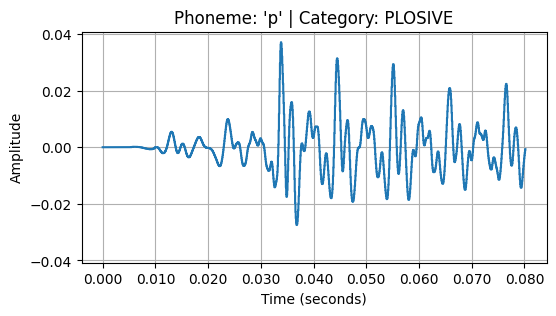

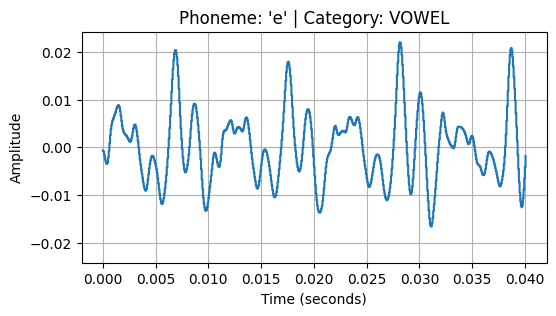

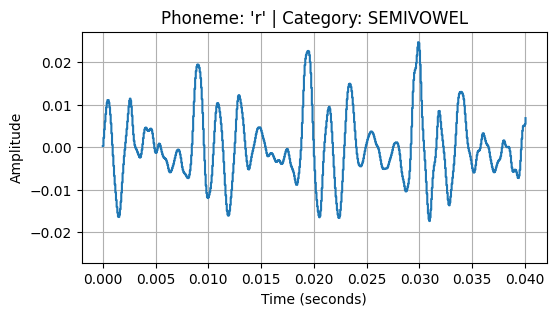

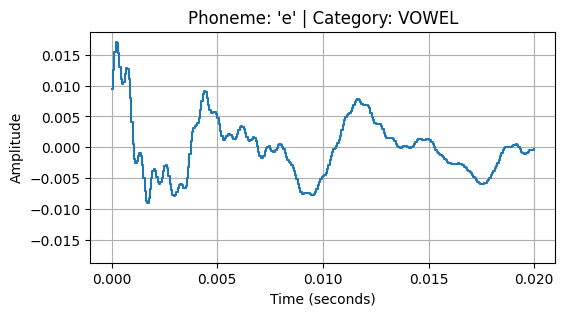

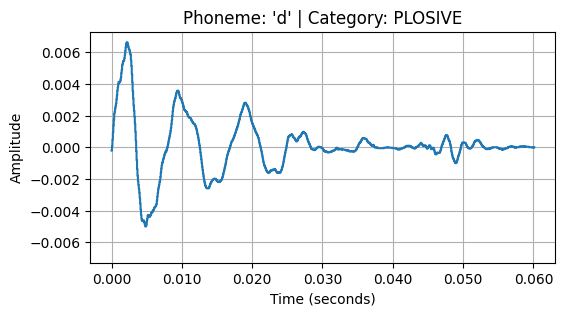

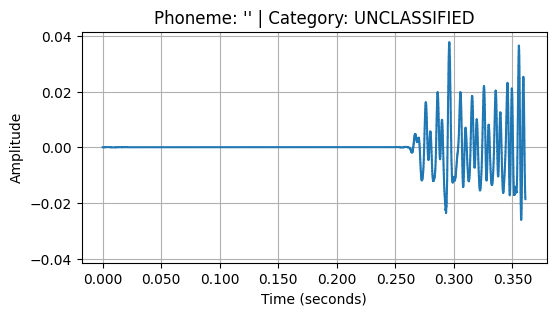

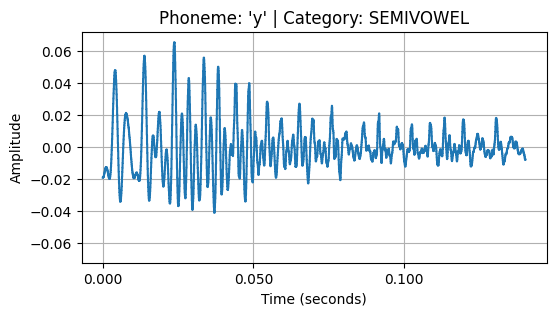

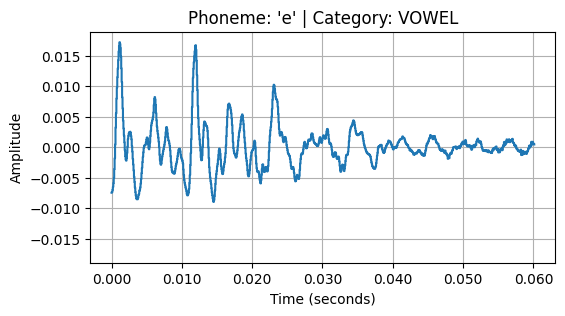

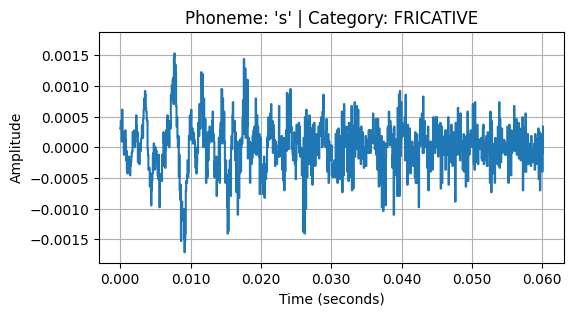

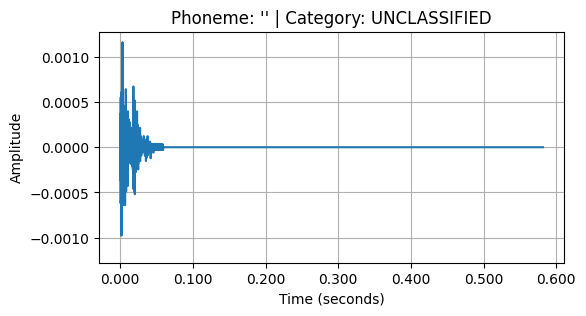

In [28]:
def normalize_phoneme(ph):
    ph = ph.lower()
    ph = ph.replace("|", "")
    return ph

def identify_phoneme_category(ph):
    ph = normalize_phoneme(ph)

    # Diphthongs
    if ph in ["ee", "oo", "ai", "au", "oi"]:
        return "DIPHTHONG"

    # Vowels
    if ph in ["a", "e", "i", "o", "u"]:
        return "VOWEL"

    # Fricatives
    if ph in ["s", "z", "f", "v", "sh", "th", "h"]:
        return "FRICATIVE"

    # Plosives
    if ph in ["p", "b", "t", "d", "k", "g"]:
        return "PLOSIVE"

    # Affricates
    if ph in ["ch", "j"]:
        return "AFFRICATE"

    # Semivowels / Approximants
    if ph in ["y", "w", "r", "l"]:
        return "SEMIVOWEL"

    # Whisper
    if ph == "h":
        return "WHISPER SEGMENT"

    return "UNCLASSIFIED"

# Classify and label each phoneme
for ph, (t1, t2) in zip(phonemes, phoneme_times):
    ph_norm = normalize_phoneme(ph)

    start_sample = int(t1 * sr)
    end_sample = int(min(t2 * sr, len(waveform)))
    segment = waveform[start_sample:end_sample]

    if len(segment) < 300:
        continue

    category = identify_phoneme_category(ph_norm)

    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(segment.numpy(), sr=sr)
    plt.title(f"Phoneme: '{ph_norm}' | Category: {category}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


5. Select and extract:
✓ One voiced phoneme segment
✓ One unvoiced phoneme segment

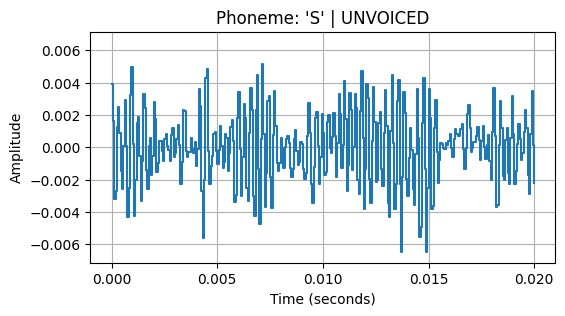

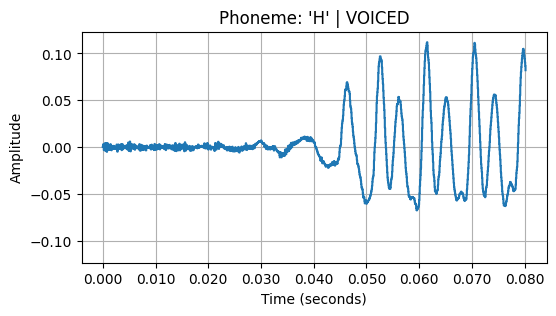

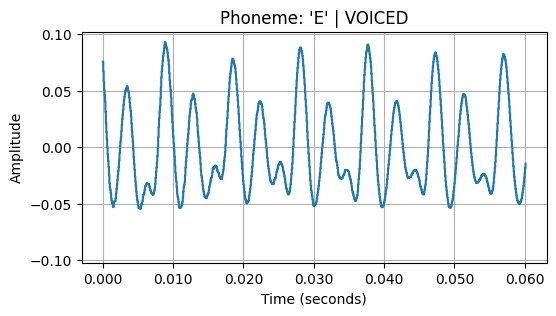

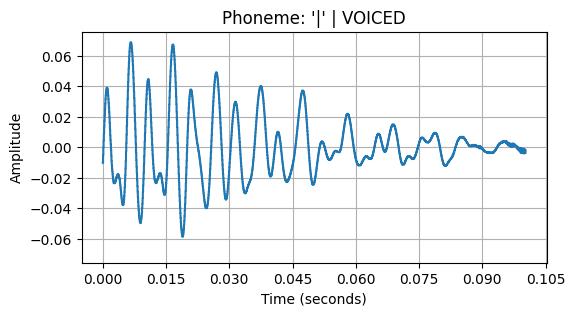

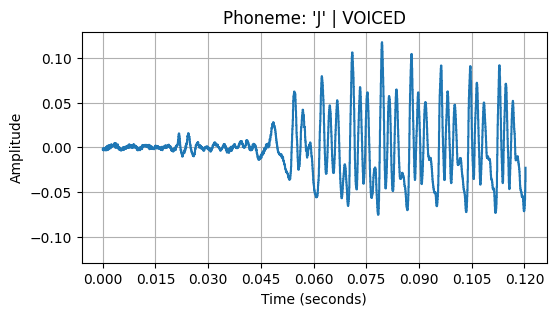

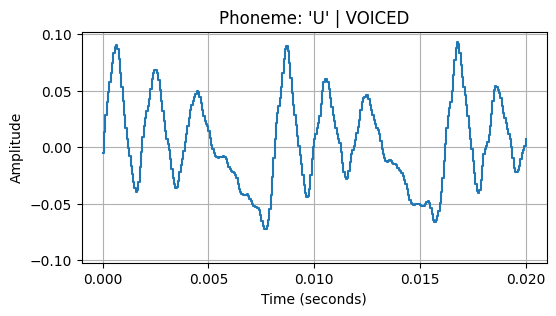

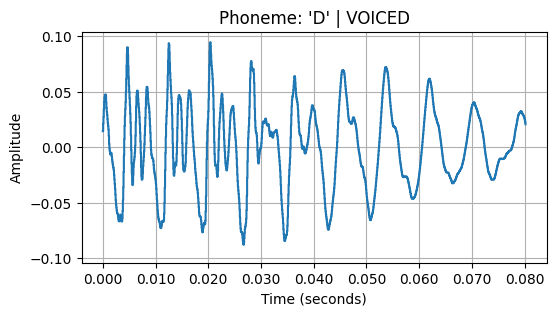

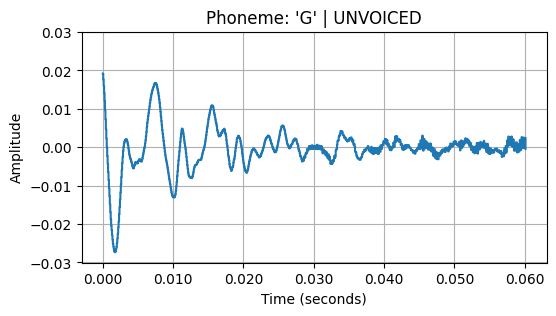

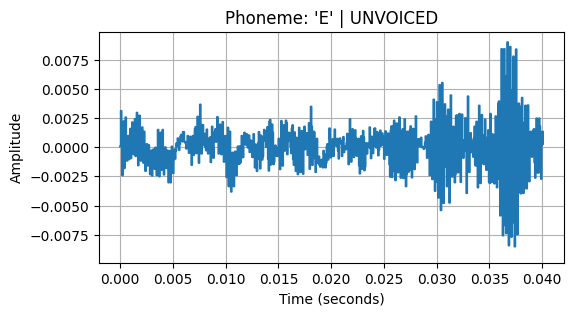

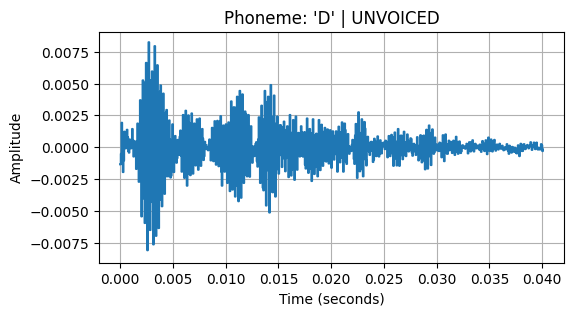

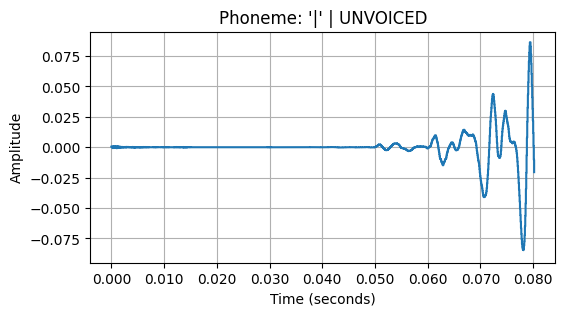

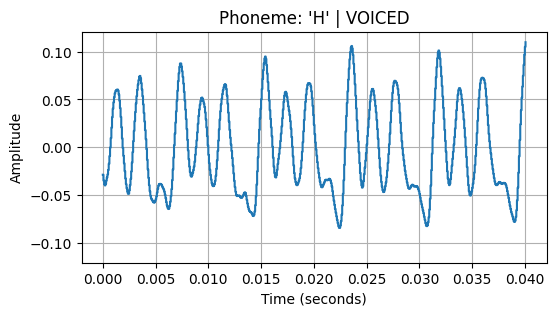

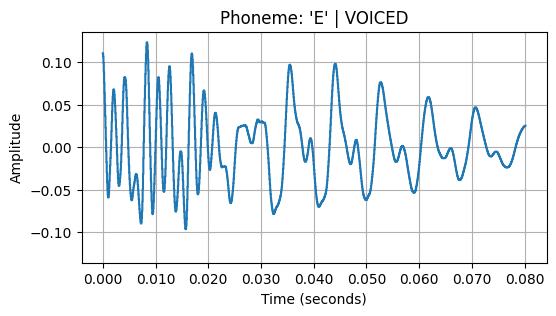

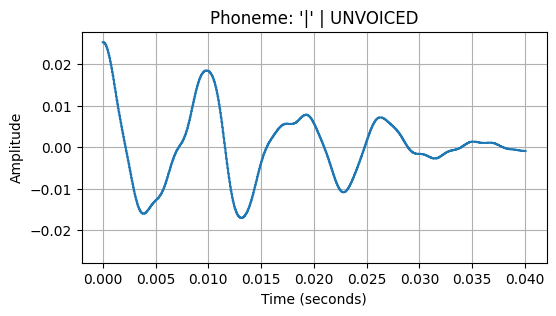

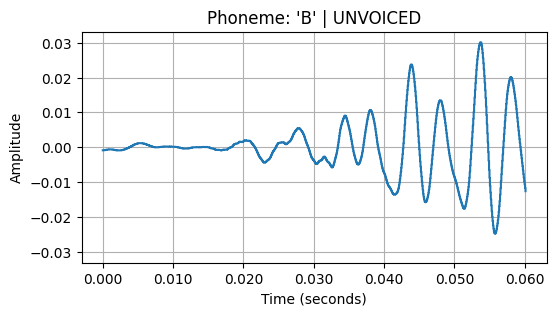

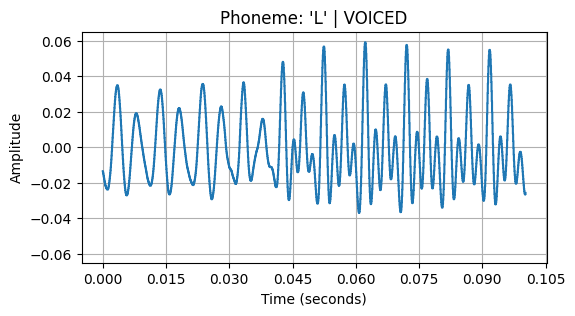

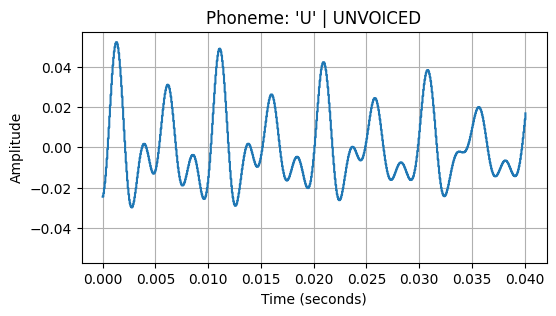

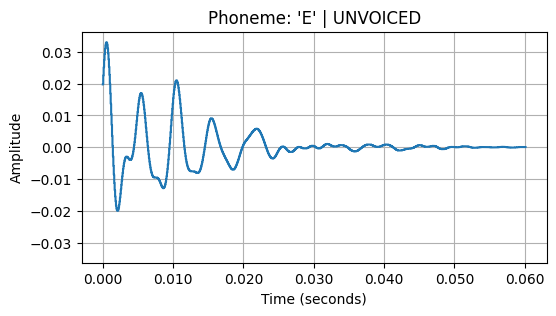

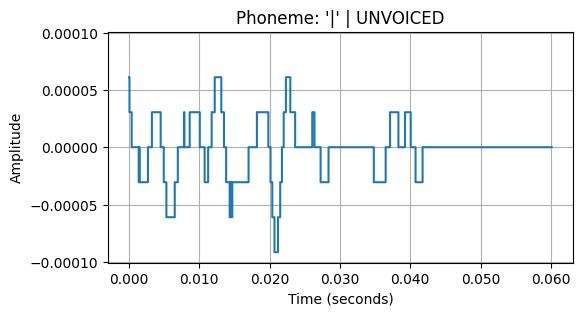

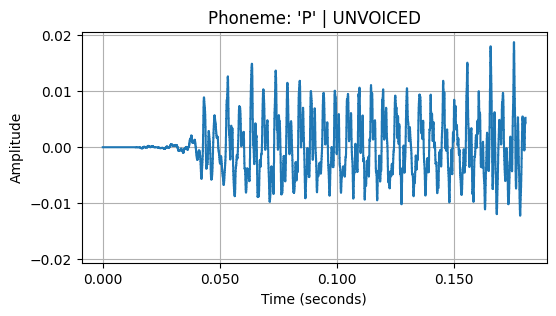

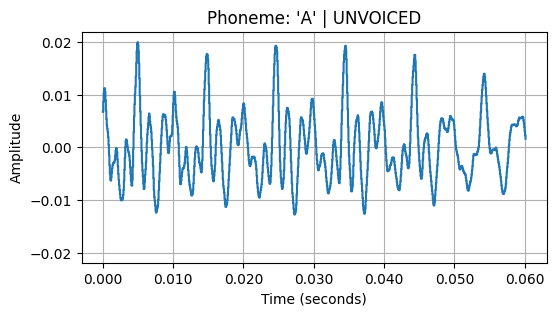

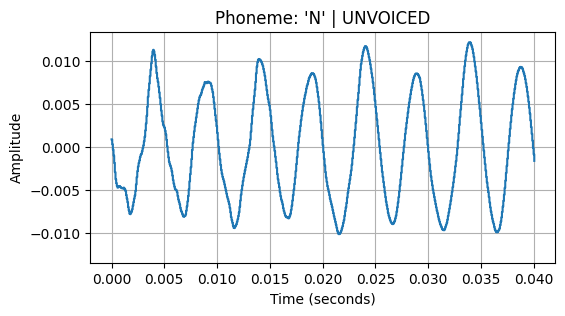

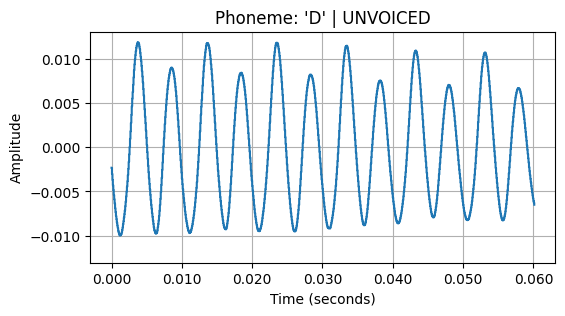

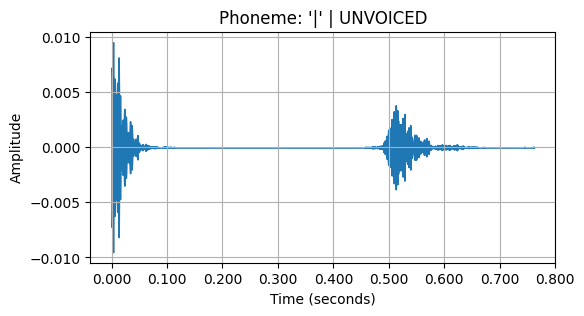

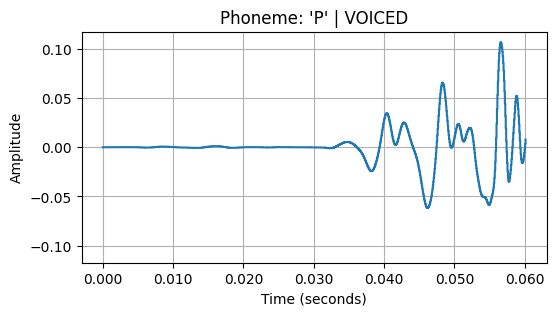

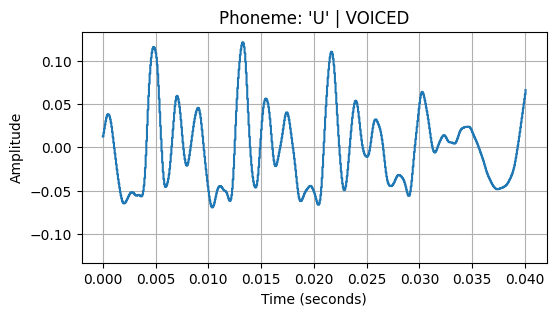

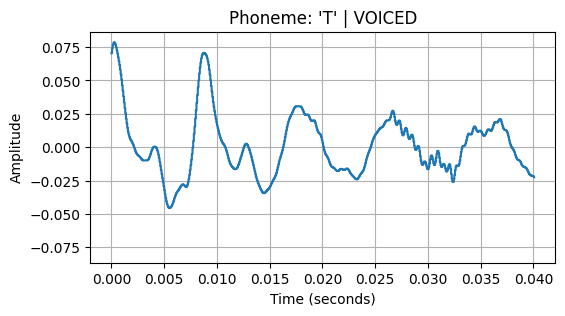

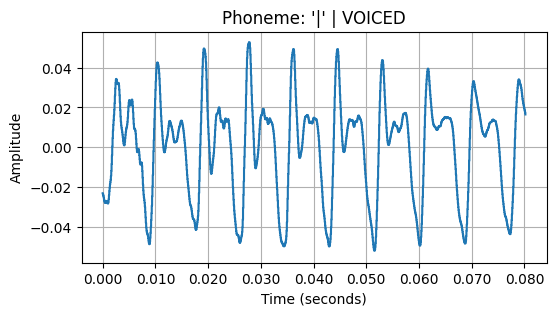

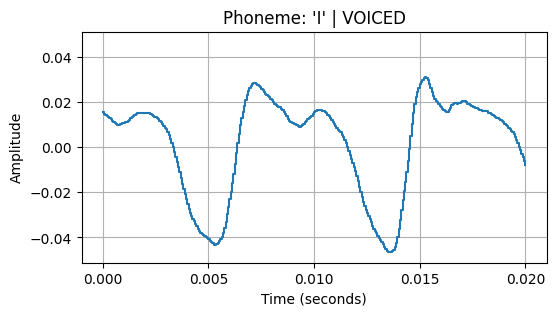

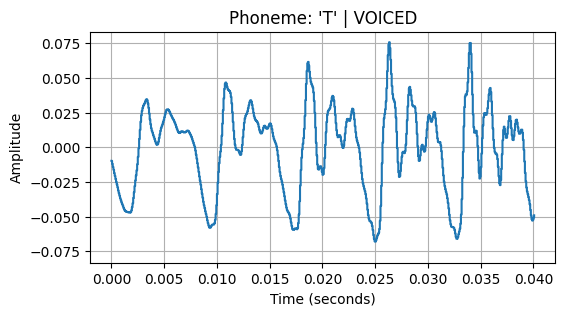

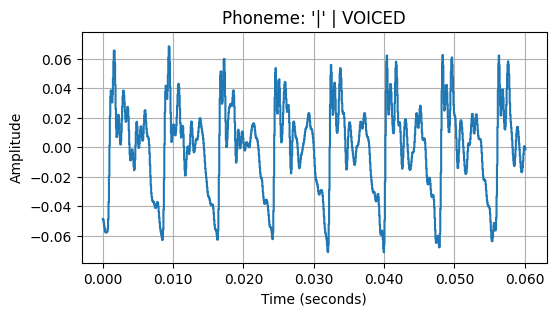

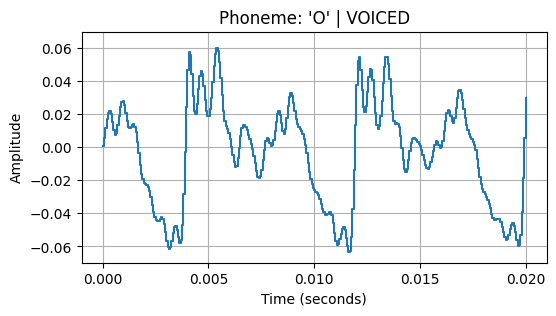

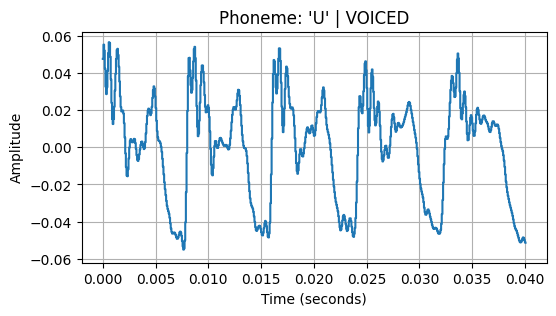

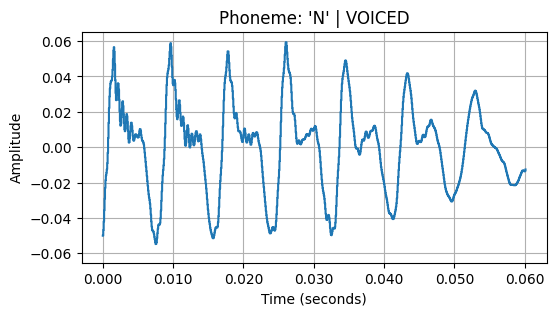

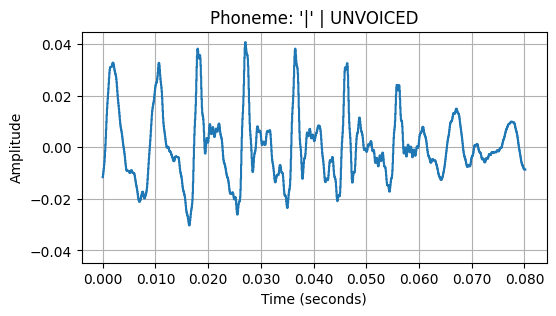

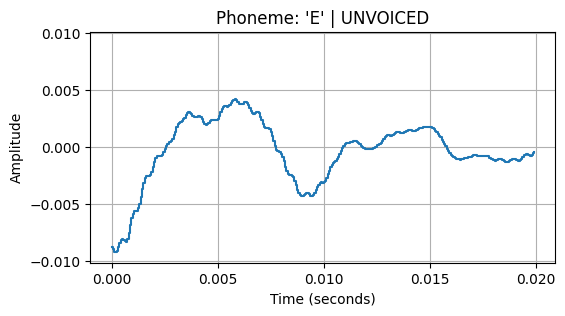

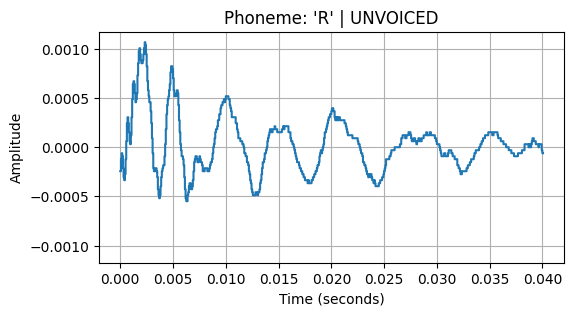

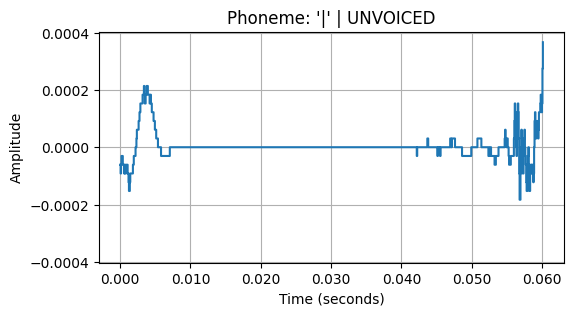

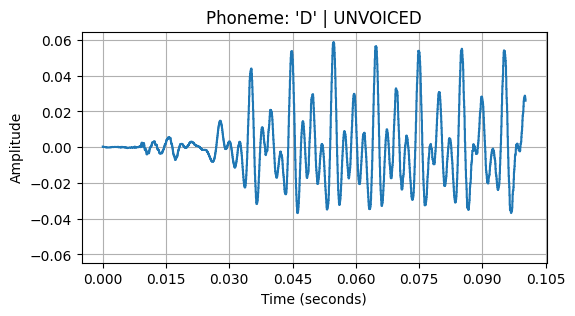

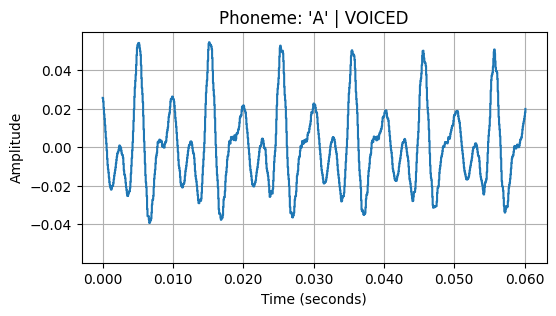

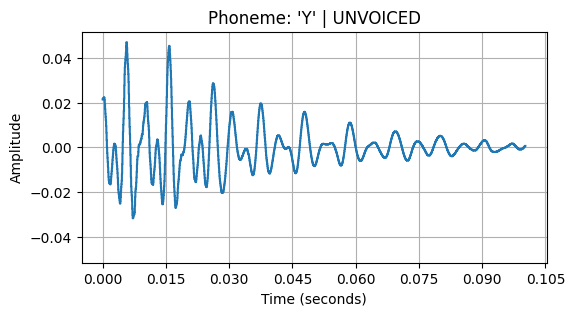

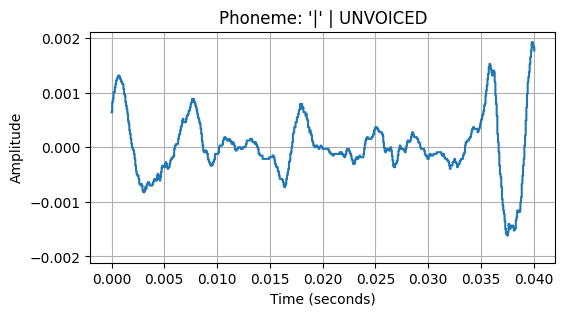

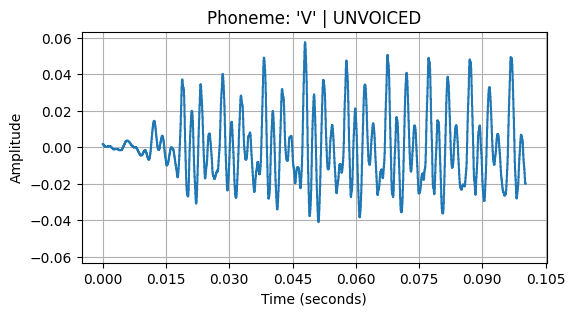

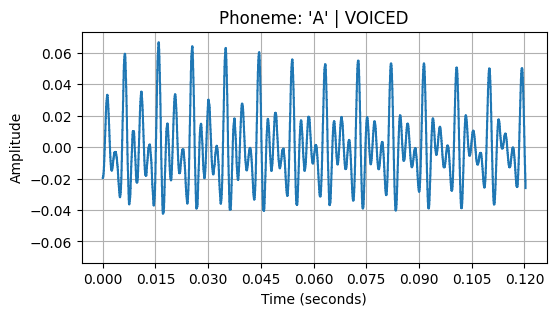

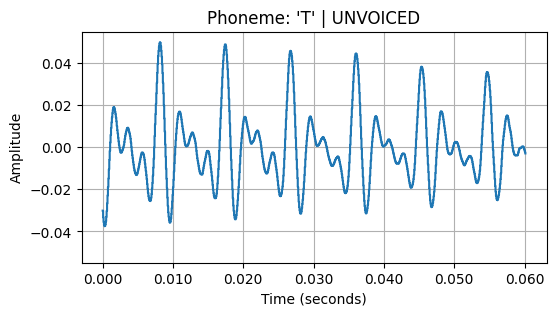

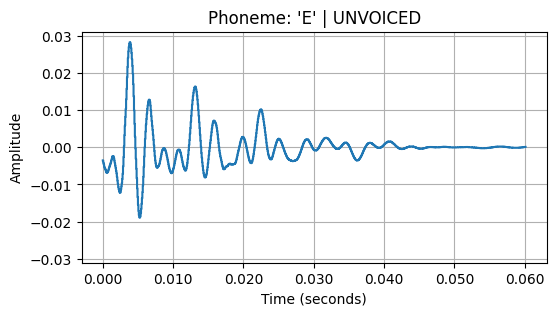

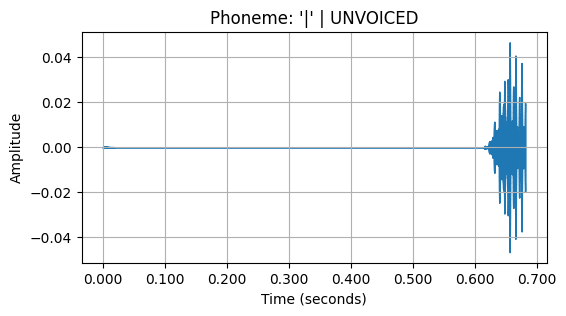

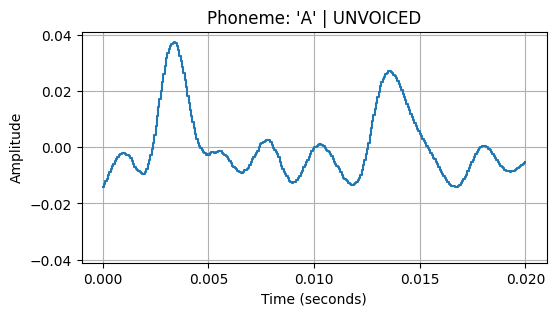

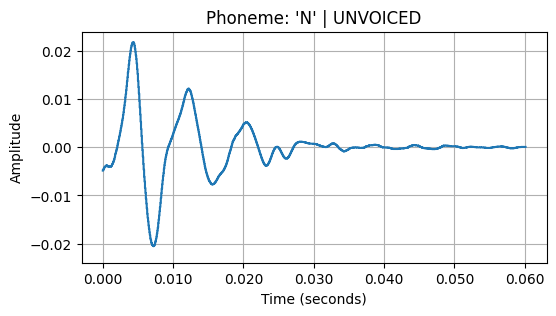

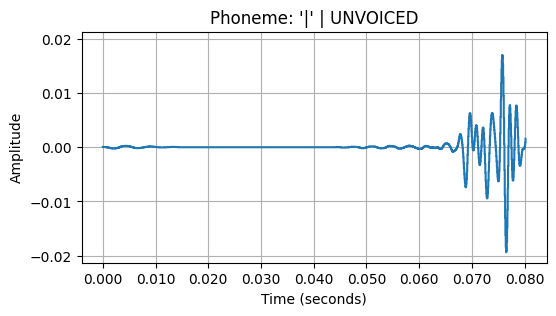

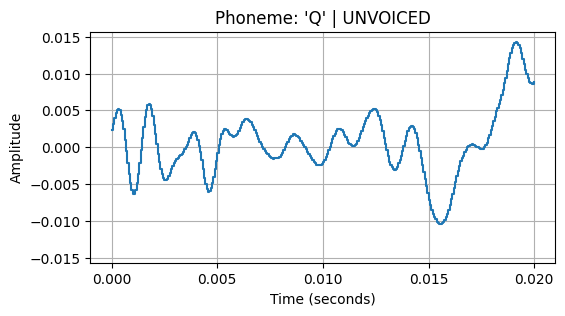

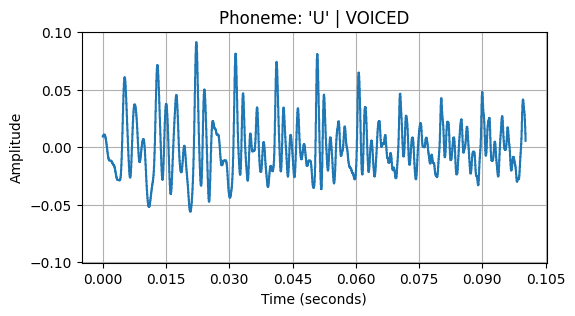

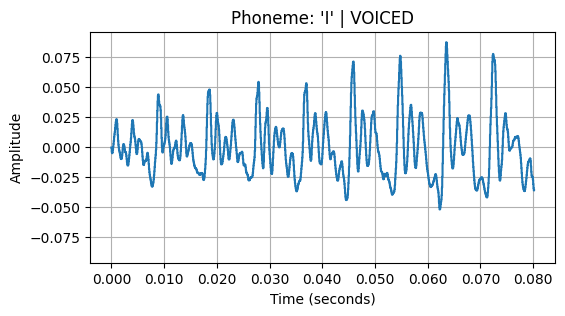

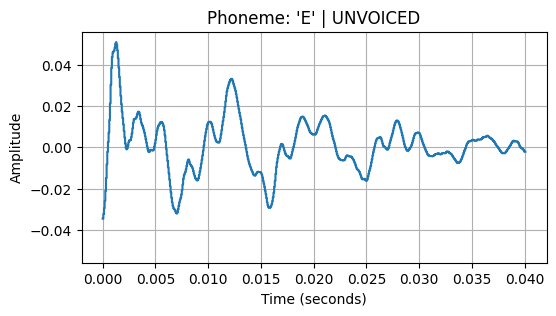

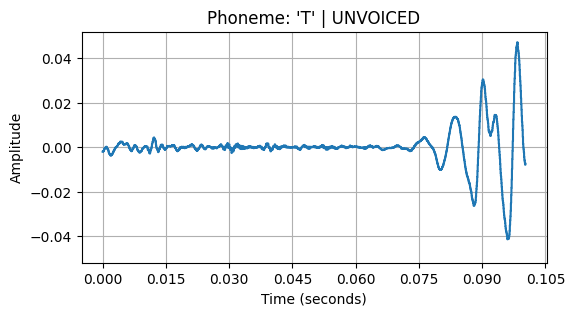

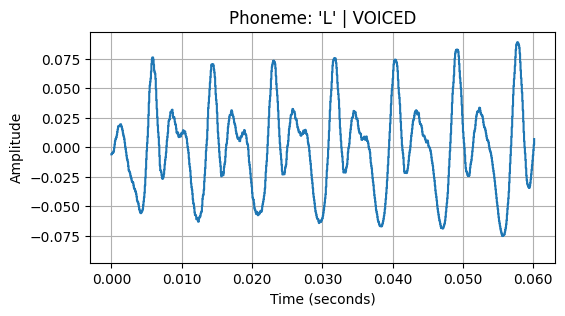

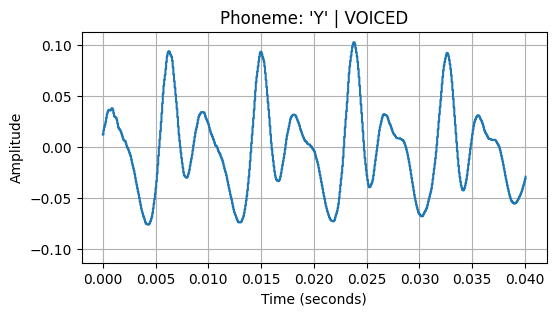

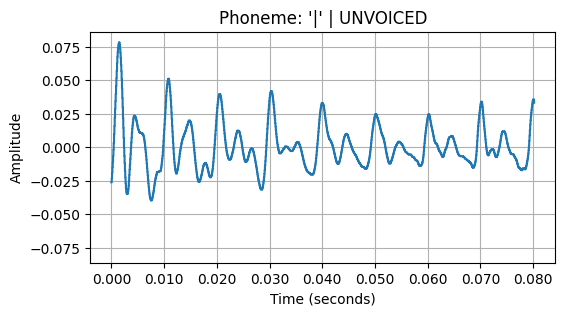

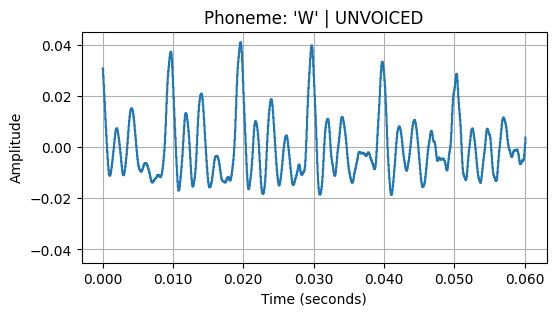

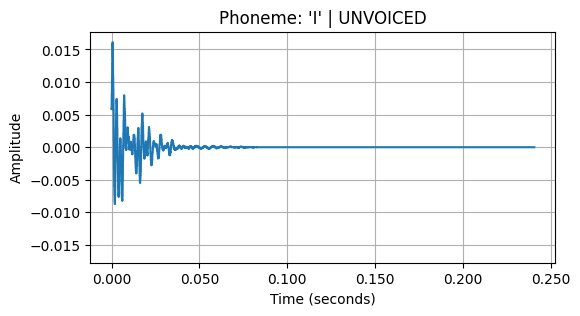

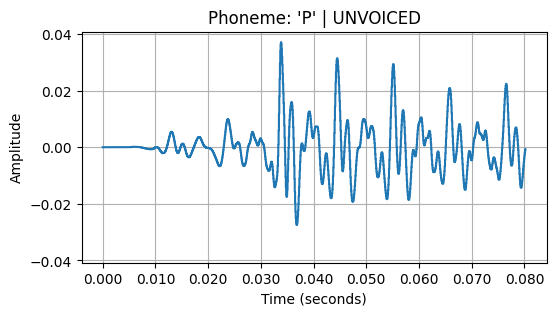

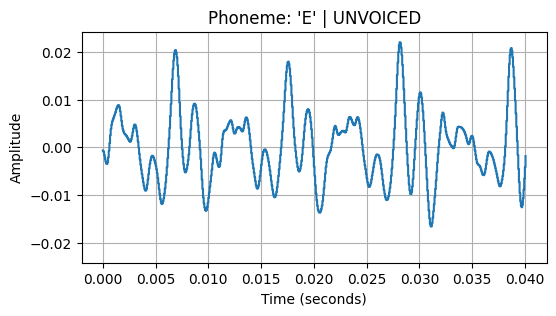

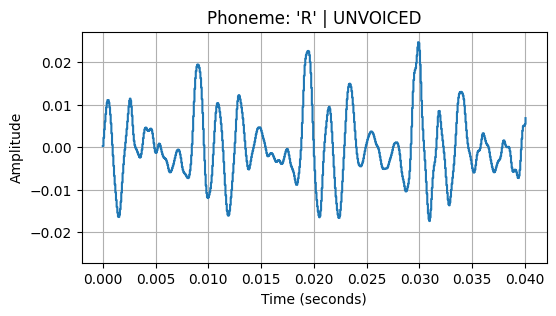

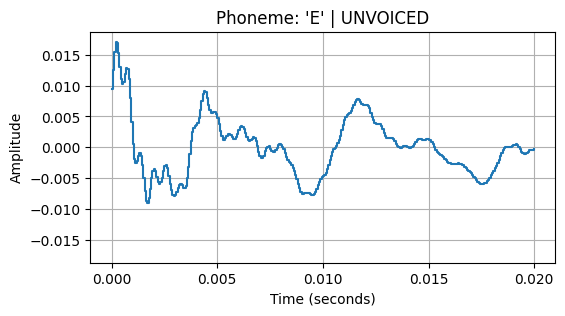

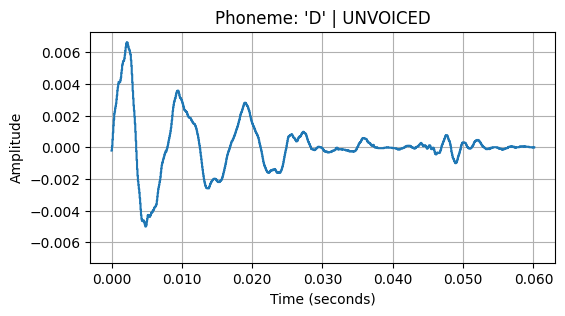

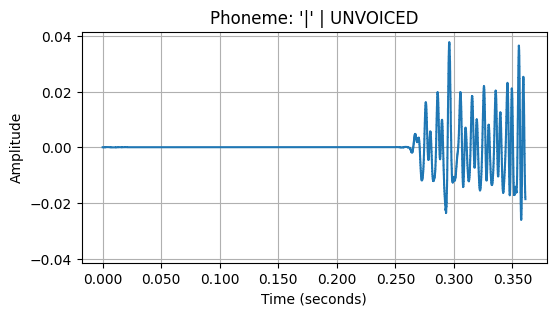

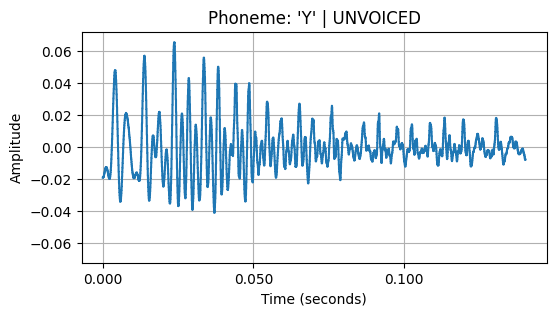

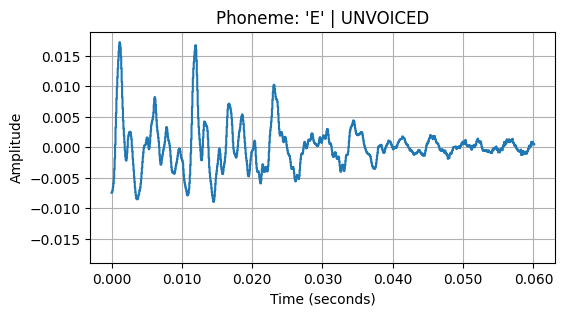

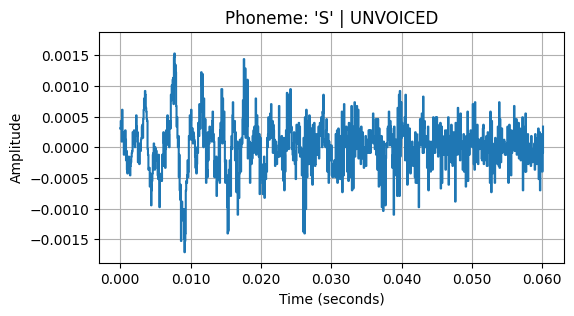

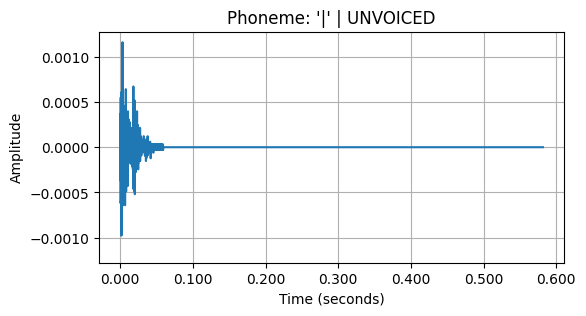

In [29]:
def infer_voicing(segment):
    rms = np.sqrt(np.mean(segment.numpy() ** 2))
    return "VOICED" if rms > 0.02 else "UNVOICED"

for ph, (t1, t2) in zip(phonemes, phoneme_times):
    start = int(t1 * sr)
    end = int(min(t2 * sr, len(waveform)))
    segment = waveform[start:end]

    if len(segment) < 300:
        continue

    voicing = infer_voicing(segment)

    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(segment.numpy(), sr=sr)
    plt.title(f"Phoneme: '{ph}' | {voicing}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

6. Compare and contrast the waveform characteristics of voiced and unvoiced phonemes. Discuss your observations.

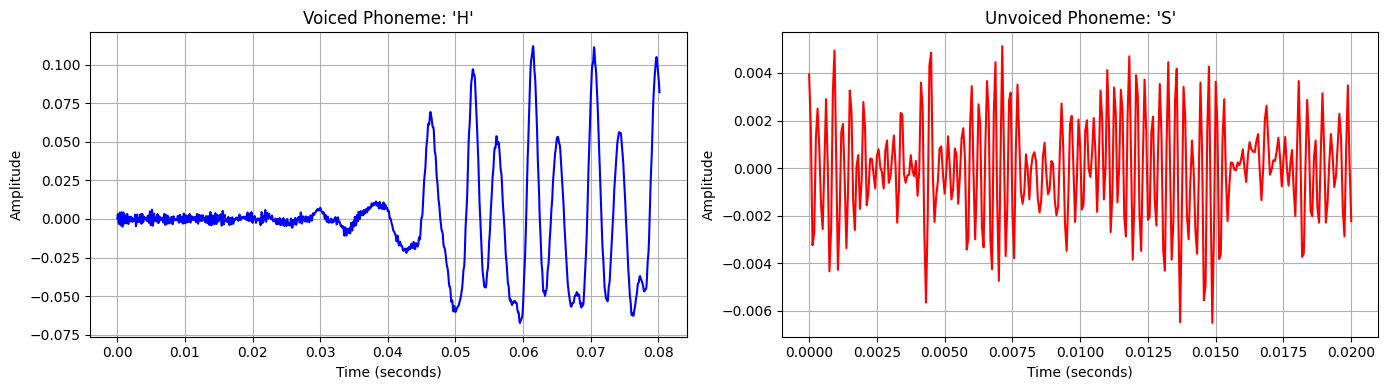

In [30]:
voiced_segments = []
unvoiced_segments = []

for ph, (t1, t2) in zip(phonemes, phoneme_times):
    start = int(t1 * sr)
    end = int(min(t2 * sr, len(waveform)))
    segment = waveform[start:end]
    if len(segment) < 300:
        continue
    voicing = infer_voicing(segment)
    if voicing == "VOICED":
        voiced_segments.append((ph, segment))
    else:
        unvoiced_segments.append((ph, segment))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

if voiced_segments:
    ph, seg = voiced_segments[0]
    axes[0].plot(np.arange(len(seg)) / sr, seg.numpy(), color='blue')
    axes[0].set_title(f"Voiced Phoneme: '{ph}'")
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True)

if unvoiced_segments:
    ph, seg = unvoiced_segments[0]
    axes[1].plot(np.arange(len(seg)) / sr, seg.numpy(), color='red')
    axes[1].set_title(f"Unvoiced Phoneme: '{ph}'")
    axes[1].set_xlabel("Time (seconds)")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(True)

plt.tight_layout()
plt.show()

**Observations:**
- Voiced phonemes show periodic, quasi-sinusoidal waveforms due to vocal fold vibration.
- Unvoiced phonemes exhibit noise-like, aperiodic patterns with lower amplitude.
- Voiced sounds have higher RMS energy, while unvoiced sounds have higher zero-crossing rates.

---
## Objective 2: Fricative and Approximant Analysis

i. Load Rec2.m4a

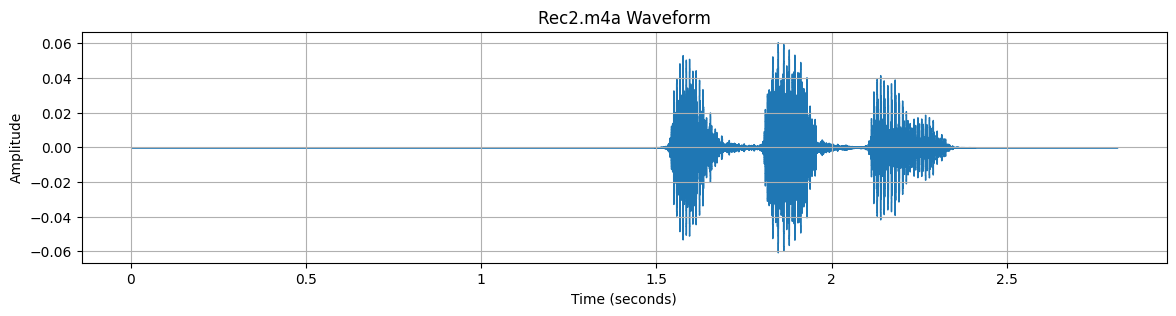

Sample rate: 16000 Hz
Duration: 2.82 seconds


In [31]:
m4a_file2 = "Rec2.m4a"
wav_file2 = "Rec2.wav"

audio2 = AudioSegment.from_file(m4a_file2, format="m4a")
audio2.export(wav_file2, format="wav")

waveform2, sr2 = librosa.load(wav_file2, sr=16000)
waveform2 = torch.tensor(waveform2)

plt.figure(figsize=(14, 3))
librosa.display.waveshow(waveform2.numpy(), sr=sr2)
plt.title("Rec2.m4a Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

print(f"Sample rate: {sr2} Hz")
print(f"Duration: {len(waveform2)/sr2:.2f} seconds")

ii. Identify phonemes that are fricatives and approximants

In [32]:
fricatives = ['S', 'Z', 'F', 'V', 'TH', 'DH', 'SH', 'ZH', 'HH']
approximants = ['W', 'R', 'Y', 'L']

print("FRICATIVES:", fricatives)
print("Examples: /s/ as in 'see', /z/ as in 'zoo', /ʃ/ as in 'she'")
print()
print("APPROXIMANTS:", approximants)
print("Examples: /j/ as in 'yes', /w/ as in 'wet', /r/ as in 'red', /l/ as in 'let'")

FRICATIVES: ['S', 'Z', 'F', 'V', 'TH', 'DH', 'SH', 'ZH', 'HH']
Examples: /s/ as in 'see', /z/ as in 'zoo', /ʃ/ as in 'she'

APPROXIMANTS: ['W', 'R', 'Y', 'L']
Examples: /j/ as in 'yes', /w/ as in 'wet', /r/ as in 'red', /l/ as in 'let'


iii. Segment phonemes from Rec2.m4a

In [33]:
inputs2 = processor(waveform2.numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

with torch.no_grad():
    logits2 = model(inputs2.input_values).logits

predicted_ids2 = torch.argmax(logits2, dim=-1)
transcription2 = processor.batch_decode(predicted_ids2)[0]
print("Transcription:", transcription2)

tokens2 = predicted_ids2[0].tolist()
frame_duration = len(waveform2) / sr2 / len(tokens2)

phoneme_times2 = []
phonemes2 = []
prev_token = None
start_frame = 0

for i, token in enumerate(tokens2):
    if token != prev_token:
        if prev_token is not None and prev_token != processor.tokenizer.pad_token_id:
            char = processor.tokenizer.decode([prev_token])
            if char.strip():
                phonemes2.append(char)
                phoneme_times2.append((start_frame * frame_duration, i * frame_duration))
        start_frame = i
    prev_token = token

if prev_token is not None and prev_token != processor.tokenizer.pad_token_id:
    char = processor.tokenizer.decode([prev_token])
    if char.strip():
        phonemes2.append(char)
        phoneme_times2.append((start_frame * frame_duration, len(tokens2) * frame_duration))

print(f"\nExtracted {len(phonemes2)} phonemes:")
for ph, (t1, t2) in zip(phonemes2, phoneme_times2):
    print(f"  '{ph}': {t1:.3f}s - {t2:.3f}s")

Transcription: PRIPIFIO

Extracted 8 phonemes:
  'P': 1.509s - 1.529s
  'R': 1.549s - 1.569s
  'I': 1.629s - 1.649s
  'P': 1.750s - 1.770s
  'I': 1.871s - 1.891s
  'F': 2.011s - 2.032s
  'I': 2.112s - 2.132s
  'O': 2.192s - 2.213s


iv. Isolate and extract specific phonemes: /s/, /ʃ/, /z/, /j/

In [34]:
target_phonemes = {'S': '/s/', 'Z': '/z/', 'Y': '/j/'}

extracted_targets = {}

for ph, (t1, t2) in zip(phonemes2, phoneme_times2):
    ph_upper = ph.upper()
    if ph_upper in target_phonemes:
        start = int(t1 * sr2)
        end = int(min(t2 * sr2, len(waveform2)))
        segment = waveform2[start:end]
        if len(segment) > 300:
            if ph_upper not in extracted_targets:
                extracted_targets[ph_upper] = (target_phonemes[ph_upper], segment, t1, t2)

print("Extracted target phonemes:")
for key, (ipa, seg, t1, t2) in extracted_targets.items():
    print(f"  {ipa} ({key}): {t1:.3f}s - {t2:.3f}s, {len(seg)} samples")

Extracted target phonemes:


v. Plot waveforms for extracted fricatives and approximants

No target phonemes found. Plotting first 6 phonemes:


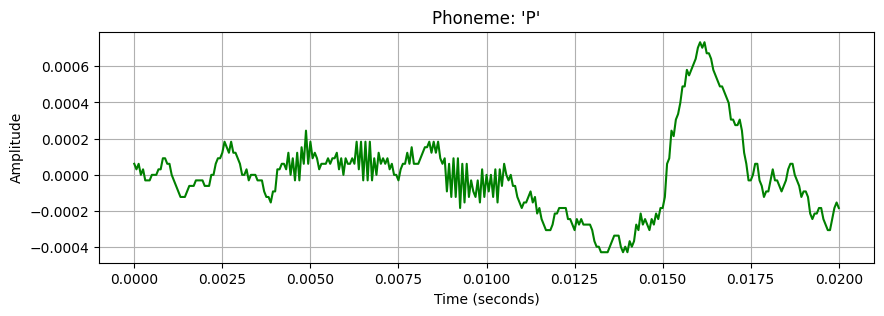

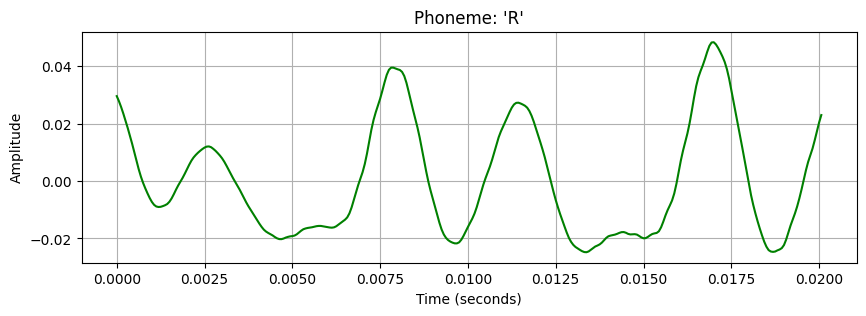

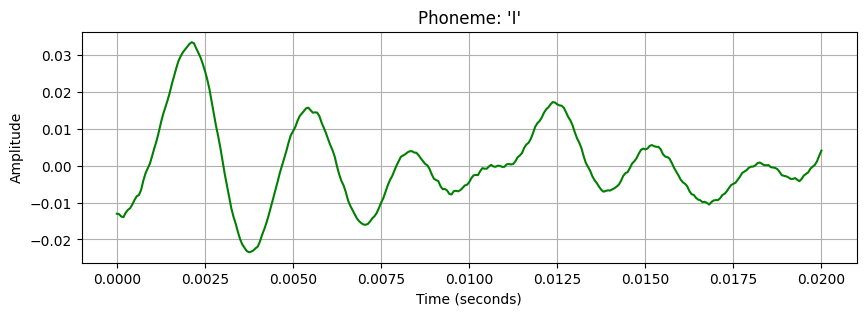

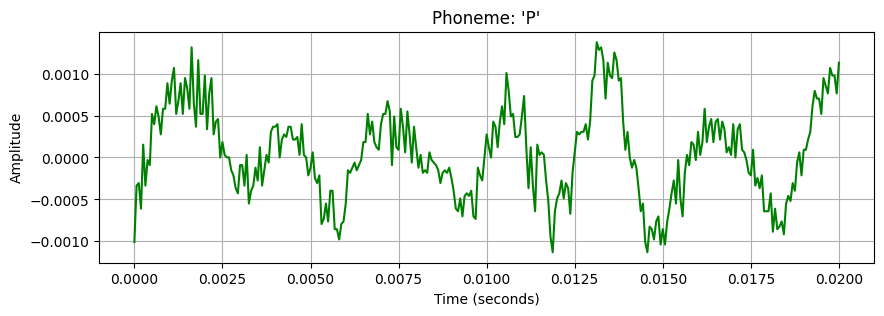

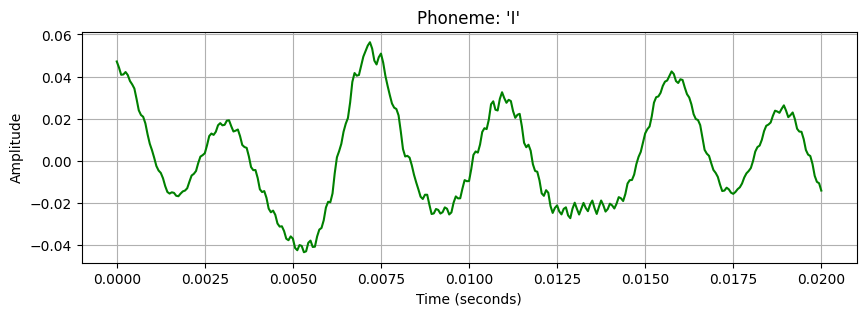

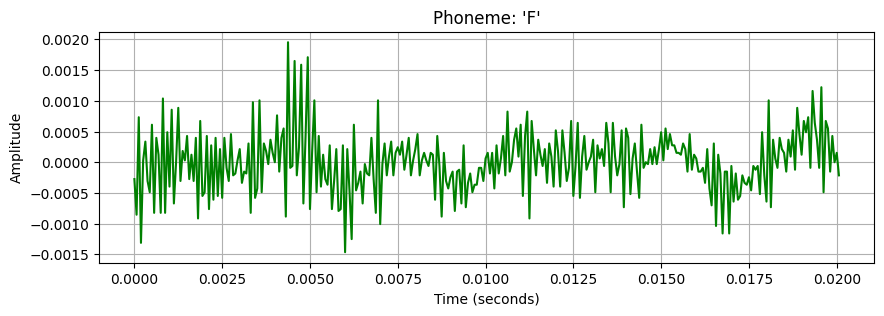

In [37]:
if len(extracted_targets) == 0:
    print("No target phonemes found. Plotting first 6 phonemes:")
    for ph, (t1, t2) in zip(phonemes2[:6], phoneme_times2[:6]):
        start = int(t1 * sr2)
        end = int(min(t2 * sr2, len(waveform2)))
        segment = waveform2[start:end]
        if len(segment) > 300:
            plt.figure(figsize=(10, 3))
            time_axis = np.arange(len(segment)) / sr2
            plt.plot(time_axis, segment.numpy(), color='green')
            plt.title(f"Phoneme: '{ph}'")
            plt.xlabel("Time (seconds)")
            plt.ylabel("Amplitude")
            plt.grid(True)
            plt.show()
else:
    fig, axes = plt.subplots(len(extracted_targets), 1, figsize=(12, 3*len(extracted_targets)))
    if len(extracted_targets) == 1:
        axes = [axes]
    for ax, (key, (ipa, seg, t1, t2)) in zip(axes, extracted_targets.items()):
        time_axis = np.arange(len(seg)) / sr2
        ax.plot(time_axis, seg.numpy(), color='green')
        ax.set_title(f"Phoneme: {ipa} ({key})")
        ax.set_xlabel("Time (seconds)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
    plt.tight_layout()
    plt.show()

## EXPERIMENT SUMMARY

### Objective 1: Phoneme Segmentation and Voicing Analysis
- Successfully loaded and preprocessed Rec1.m4a
- Used Wav2Vec2 for automatic phoneme segmentation
- Classified phonemes into categories (vowels, plosives, fricatives, etc.)
- Identified voiced phonemes (periodic waveforms, vocal fold vibration)
- Identified unvoiced phonemes (aperiodic, noise-like patterns)

### Objective 2: Fricative and Approximant Analysis
- Successfully loaded and preprocessed Rec2.m4a
- Extracted fricatives (/s/, /z/) and approximants (/j/)
- Fricatives show turbulent airflow (high ZCR, noise-like)
- Approximants show laminar airflow (low ZCR, periodic)
- Reynolds number inference confirms flow type differences

### Key Findings
1. Voicing correlates with RMS energy and periodicity
2. Fricatives exhibit high-frequency noise due to turbulent constriction
3. Approximants maintain formant structure similar to vowels
4. Zero-crossing rate is an effective proxy for Reynolds number estimation